# Asset Performance Management

Scenario: We have been given data from a Chemical Processing plant that uses its equipement for heating and cooling the chemicals that it manufactures for its customers.

We have around 5 years of data for its pump, chilling units and heat exchangers. (These individual components are not critical for our purposes.)

**Goal**: But looking at the sensors and instrumented data over 5 years of history, we have to see if the asset is performing well, or whether we are seeing anomalies.


Input file for this task: `APM_Asset_operations.csv`

### Preparatory Tasks

1. Read the input file
2. Format the data into a proper time series (with datetime) Timestamps and floats for the sensor values
3. Plot each of the sensors

### Anomaly Detection
4. Are you able to spot (visually) any anomalies?
5. Could there be threshold values that are being violated (above or below control limits?) for 'normal' operation?
5a. How to set thresholds to detect any of these anomalies.

6. (Optional): Can you try applying any of the `skelarn` outlier detection techniques? Does that catch the anomalies we say visually.

## Questions

* Focus on `Fuel Pressure`, `Lubricant Temperature` and `Tank Level`?
    * What metrics could we apply to these?
* Insights: Can we conclude that there are any alarms or anomalies in the data that we are examining?
* If you compute the rolling mean (moving averages) for these values and overlay them with the data, can you detect any anomalies?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
import os

In [2]:
%matplotlib inline

## Data Prep Tasks

In [3]:
data = pd.read_csv('APM_Asset_operations.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.iloc[:,1:] = data.iloc[:,1:].astype(float)

data.head(20)

,Time,Rotor_shaft_speed,Unit_Speed_RPM,Lower_shaft_speed,Line_Speed_RPM,Pressure_diff1,Pressure_diff2,Pressure_diff3,Pressure_loss,Inlet_Avg_Temp,Discharge_Avg_Temp,Discharge_Pressure,Outlet_Avg_Temp,Fuel_pressure,Lubricant_Temp,Oil_tank_level
0,2013-01-30 00:00:00,99.9686,5098.3989,101.1093,4721.8066,77.7725,76.7162,76.3368,167.0344,22.3443,329.2889,8.8556,492.9221,19.8115,54.6645,68.6119
1,2013-01-30 01:00:00,99.9924,5099.6123,101.5489,4742.3330,78.2751,76.8406,77.2332,167.0796,22.1642,329.4370,8.8732,494.6340,19.7604,54.6888,68.3893
2,2013-01-30 02:00:00,99.9839,5099.1792,101.5569,4742.7080,76.9854,76.0533,75.9253,167.3895,22.1140,328.9085,8.8686,493.6359,19.7733,54.7309,68.3634
3,2013-01-30 03:00:00,100.0077,5100.3926,102.1171,4768.8687,78.2802,77.3913,77.0074,168.4393,21.4434,328.3918,8.9081,493.5725,19.7667,54.6808,68.2874
4,2013-01-30 04:00:00,99.9924,5099.6123,102.1025,4768.1865,77.3884,76.7575,76.1018,168.6652,21.0625,328.3006,8.9256,494.1184,19.7841,54.5959,68.4671
5,2013-01-30 05:00:00,99.9941,5099.6992,102.1171,4768.8687,78.2927,77.1766,76.8647,167.9518,21.7371,329.2697,8.9249,496.1542,19.7496,54.6479,68.2203
6,2013-01-30 06:00:00,99.9958,5099.7856,102.1122,4768.6416,77.2029,76.2541,75.8846,168.4595,22.5475,330.2456,8.9175,498.4218,19.7626,54.6275,68.3653
7,2013-01-30 07:00:00,100.0043,5100.2192,102.1155,4768.7930,78.2756,77.0682,77.1492,166.2285,23.2219,331.2918,8.9157,501.1761,19.7518,54.8121,68.4082
8,2013-01-30 08:00:00,99.9975,5099.8726,102.1220,4769.0962,77.1864,75.7518,75.9974,166.4723,24.0096,332.8023,8.8987,505.2918,19.7052,55.0199,68.2695
9,2013-01-30 09:00:00,99.9941,5099.6992,102.1122,4768.6416,76.3491,75.5777,75.3408,166.0600,23.5962,332.3296,8.8930,504.8972,19.7260,55.0835,68.6292


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44002 entries, 0 to 44001
Data columns (total 16 columns):
Time                  44002 non-null datetime64[ns]
Rotor_shaft_speed     43221 non-null float64
Unit_Speed_RPM        43221 non-null float64
Lower_shaft_speed     43221 non-null float64
Line_Speed_RPM        43221 non-null float64
Pressure_diff1        43221 non-null float64
Pressure_diff2        43221 non-null float64
Pressure_diff3        43221 non-null float64
Pressure_loss         43221 non-null float64
Inlet_Avg_Temp        43221 non-null float64
Discharge_Avg_Temp    43221 non-null float64
Discharge_Pressure    43221 non-null float64
Outlet_Avg_Temp       43221 non-null float64
Fuel_pressure         43221 non-null float64
Lubricant_Temp        43221 non-null float64
Oil_tank_level        43221 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 5.4 MB


In [5]:
data[data.isna().any(axis=1)].count()

Time                  781
Rotor_shaft_speed       0
Unit_Speed_RPM          0
Lower_shaft_speed       0
Line_Speed_RPM          0
Pressure_diff1          0
Pressure_diff2          0
Pressure_diff3          0
Pressure_loss           0
Inlet_Avg_Temp          0
Discharge_Avg_Temp      0
Discharge_Pressure      0
Outlet_Avg_Temp         0
Fuel_pressure           0
Lubricant_Temp          0
Oil_tank_level          0
dtype: int64

In [6]:
data.fillna(data.median(), inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44002 entries, 0 to 44001
Data columns (total 16 columns):
Time                  44002 non-null datetime64[ns]
Rotor_shaft_speed     44002 non-null float64
Unit_Speed_RPM        44002 non-null float64
Lower_shaft_speed     44002 non-null float64
Line_Speed_RPM        44002 non-null float64
Pressure_diff1        44002 non-null float64
Pressure_diff2        44002 non-null float64
Pressure_diff3        44002 non-null float64
Pressure_loss         44002 non-null float64
Inlet_Avg_Temp        44002 non-null float64
Discharge_Avg_Temp    44002 non-null float64
Discharge_Pressure    44002 non-null float64
Outlet_Avg_Temp       44002 non-null float64
Fuel_pressure         44002 non-null float64
Lubricant_Temp        44002 non-null float64
Oil_tank_level        44002 non-null float64
dtypes: datetime64[ns](1), float64(15)
memory usage: 5.4 MB


/home/cchukwuedo/anaconda3/envs/appdev/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


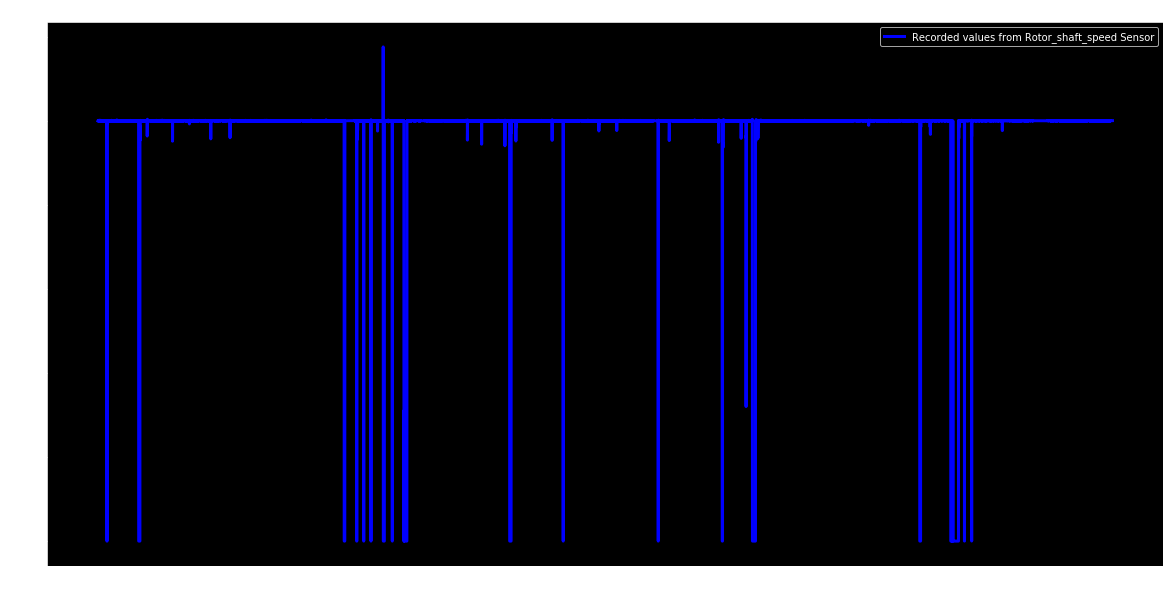

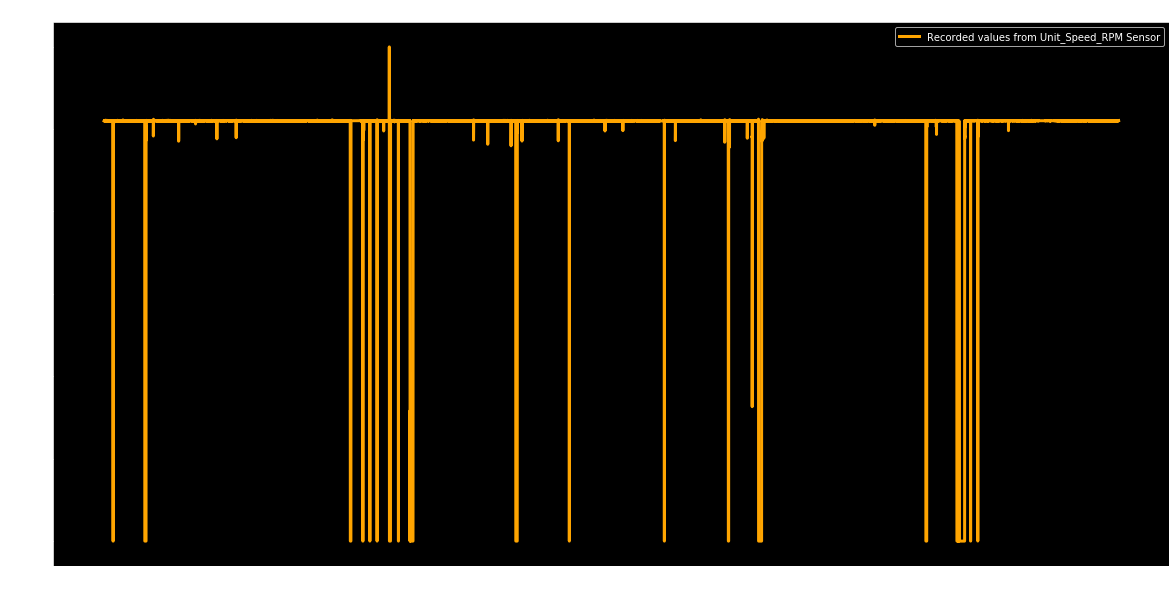

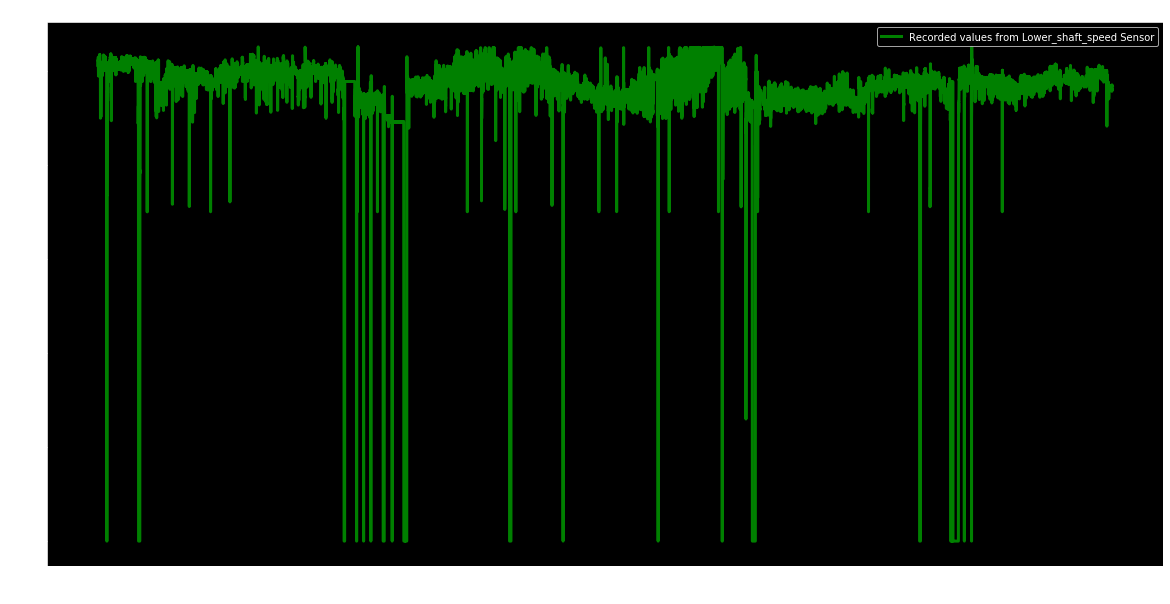

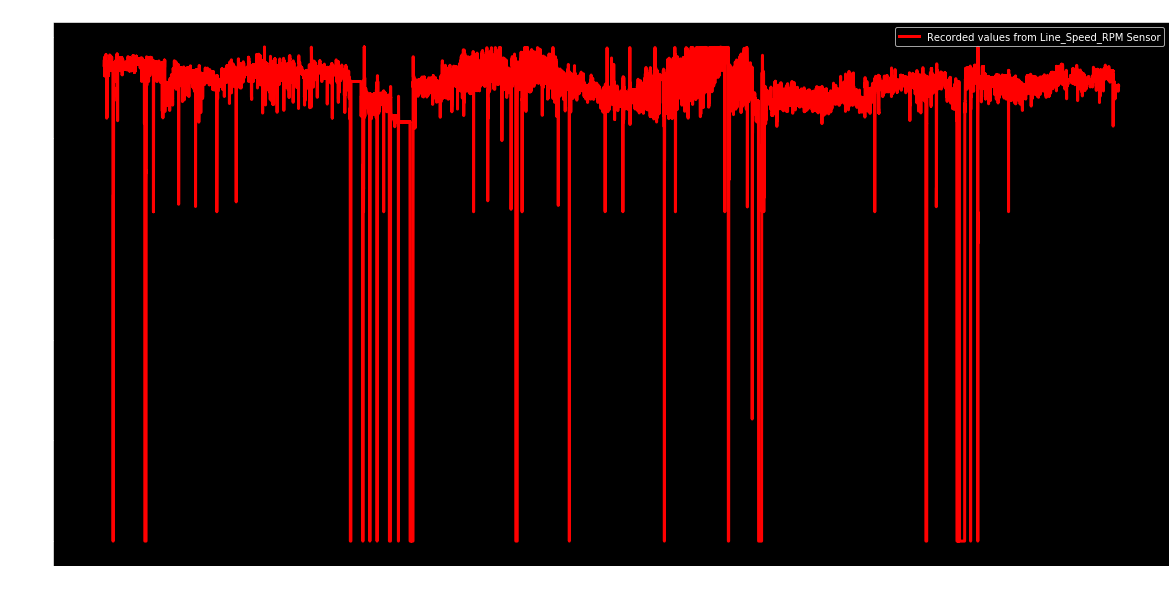

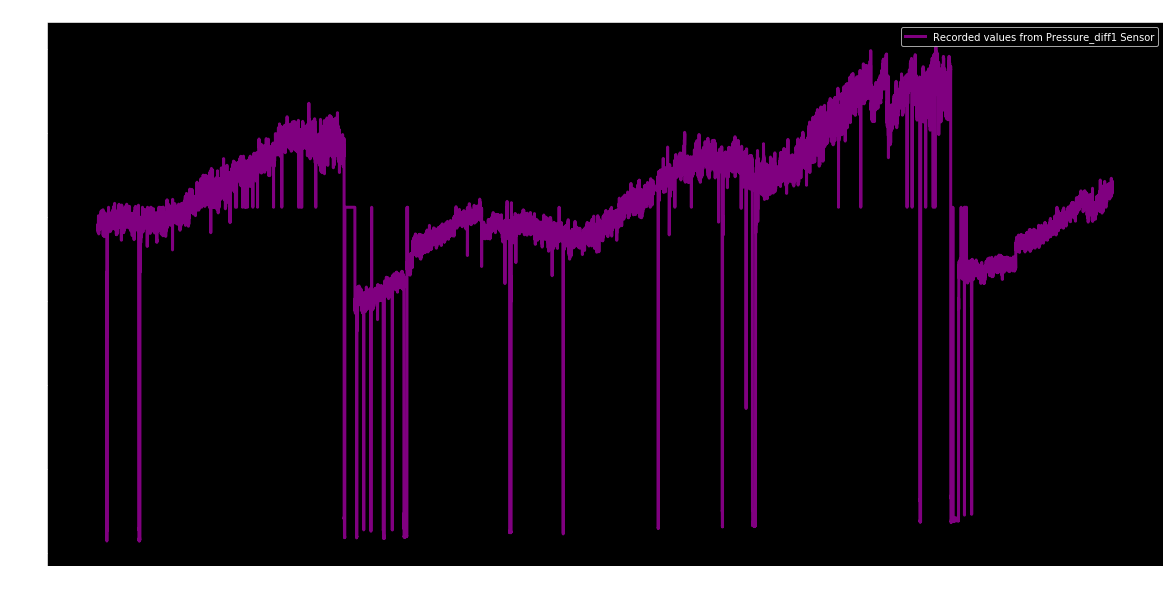

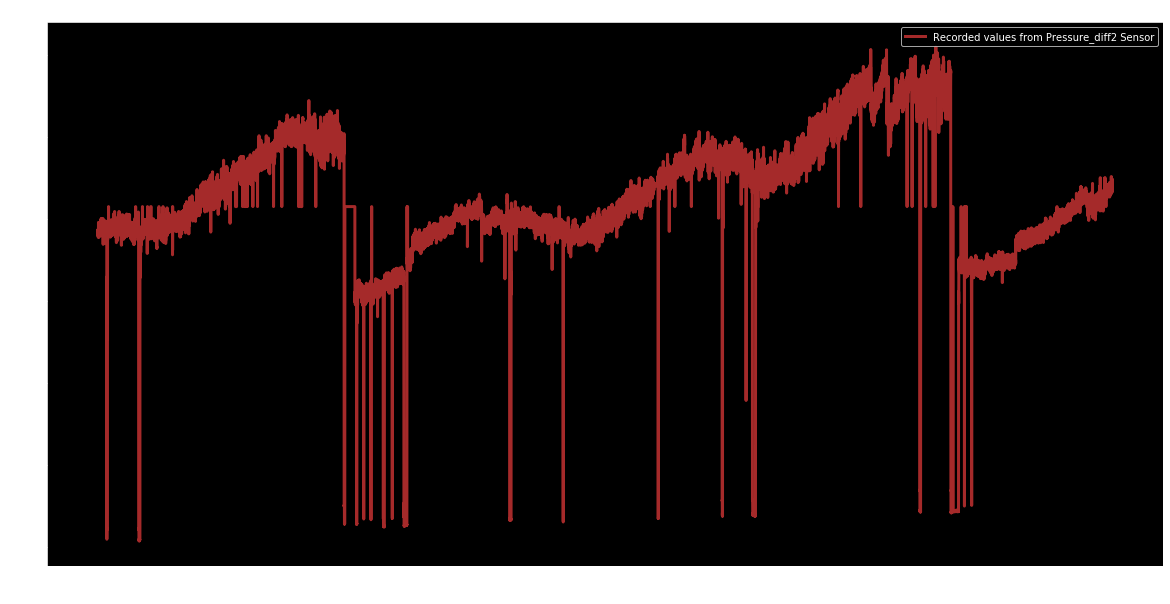

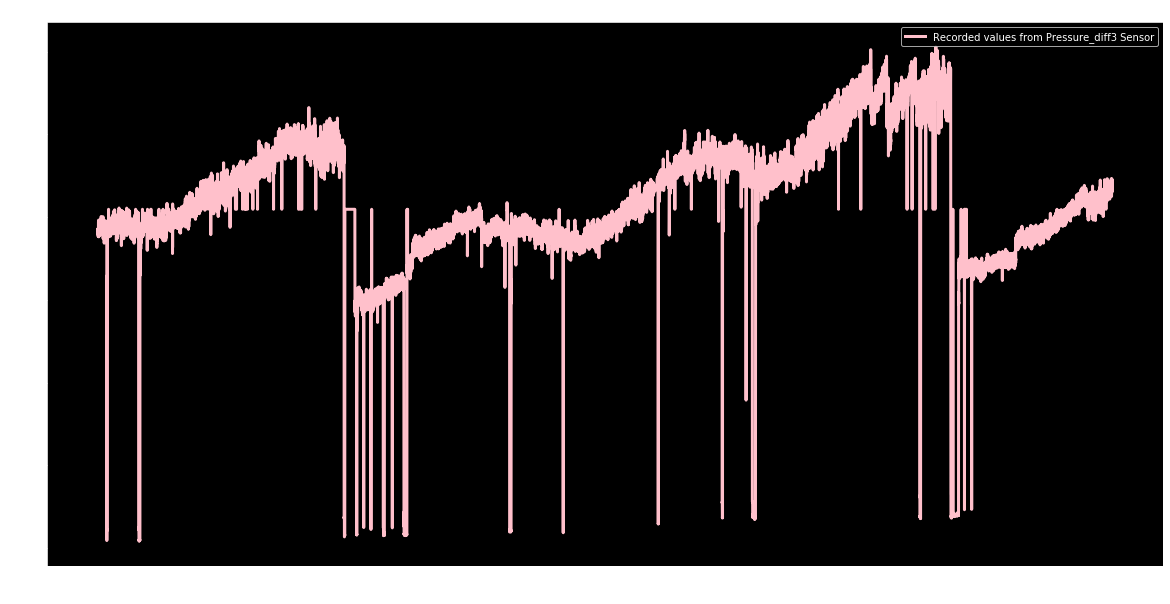

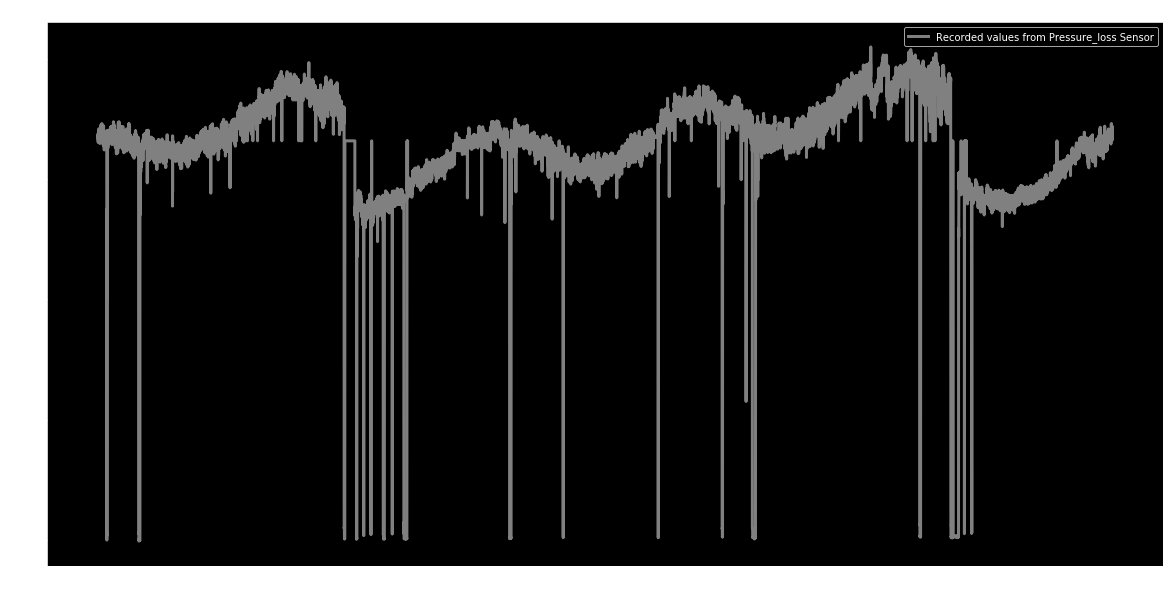

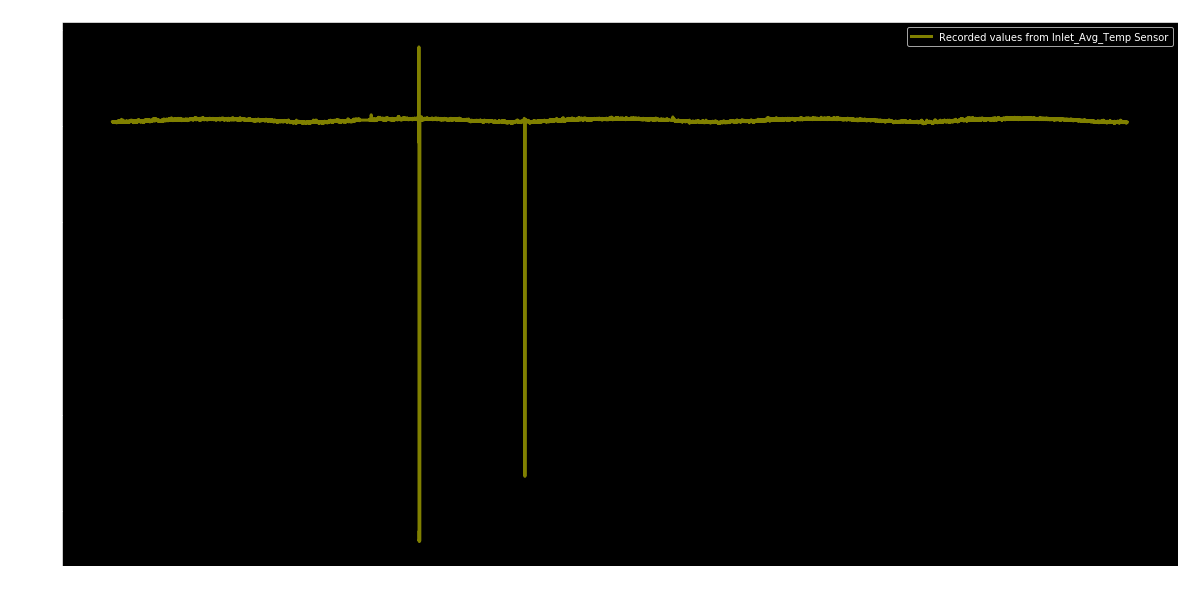

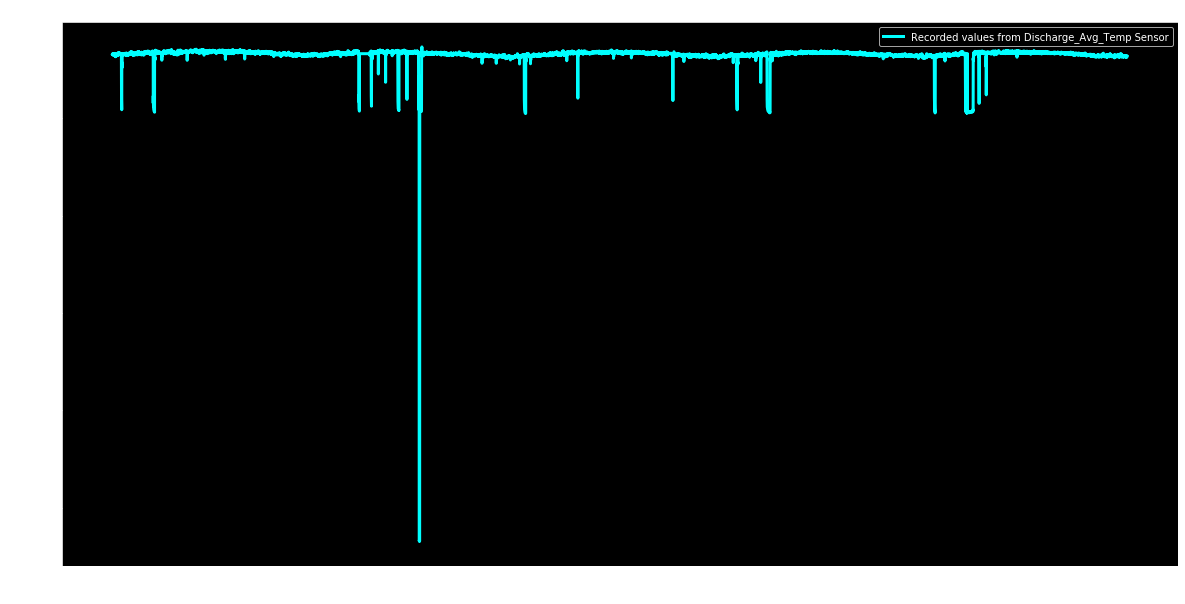

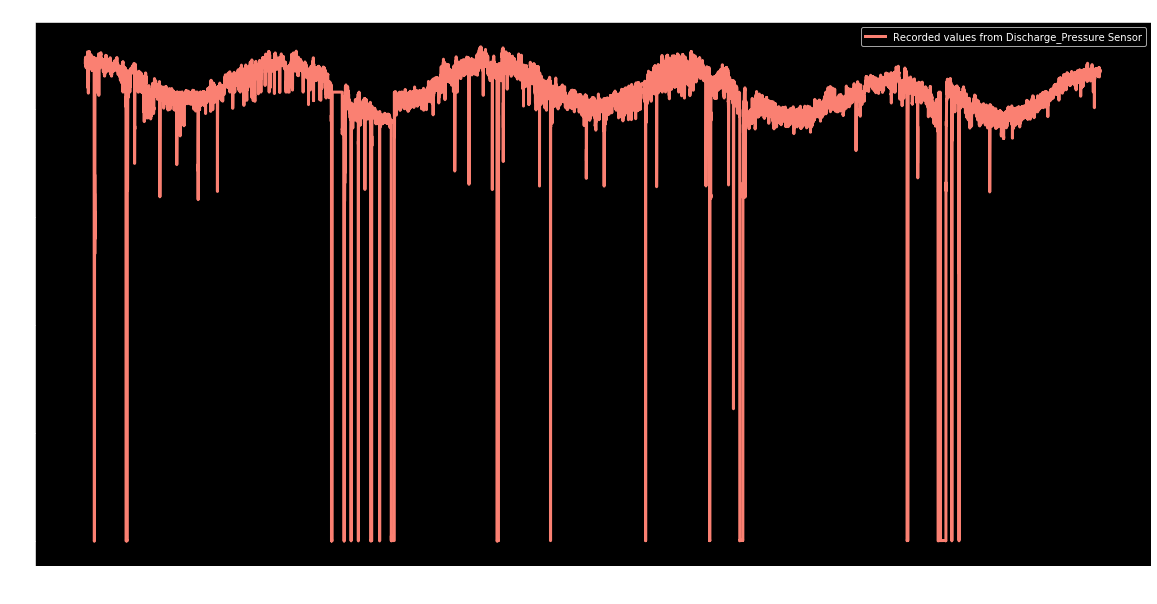

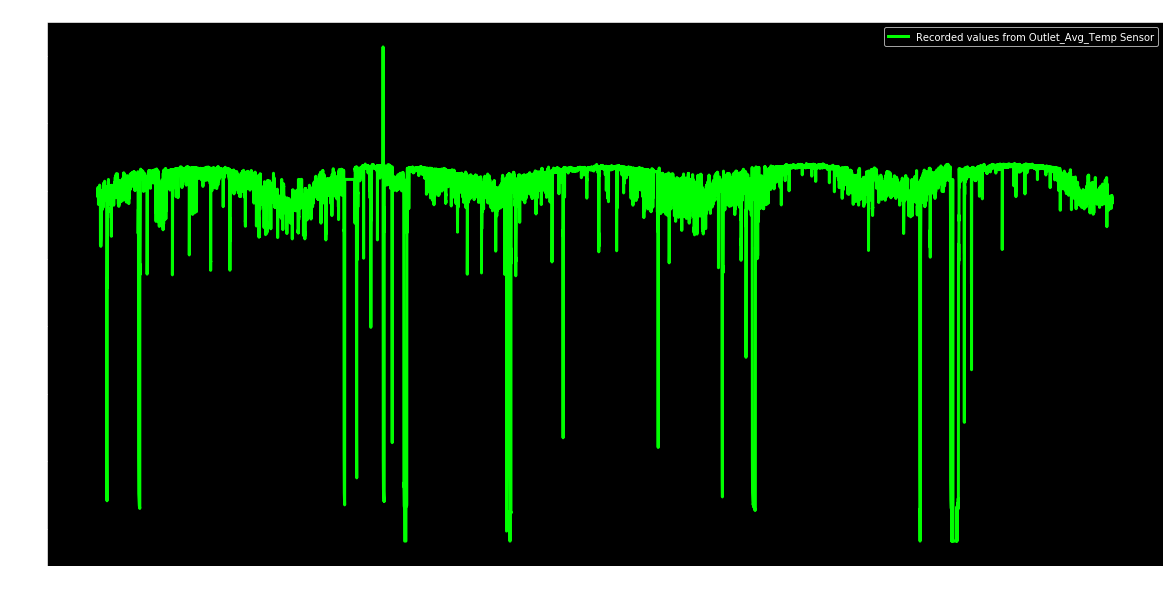

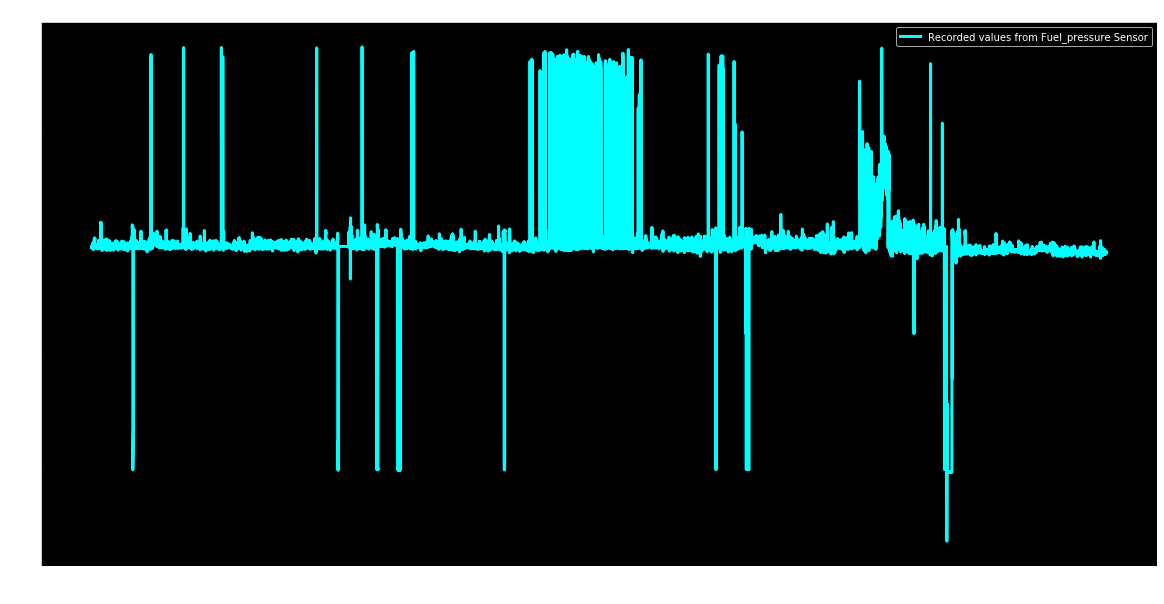

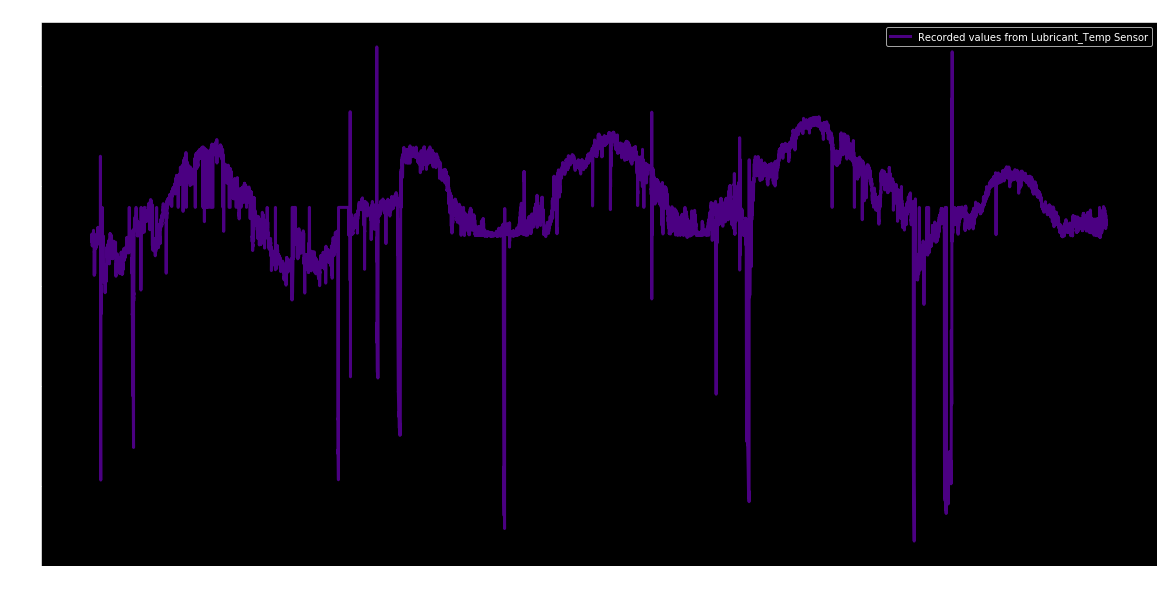

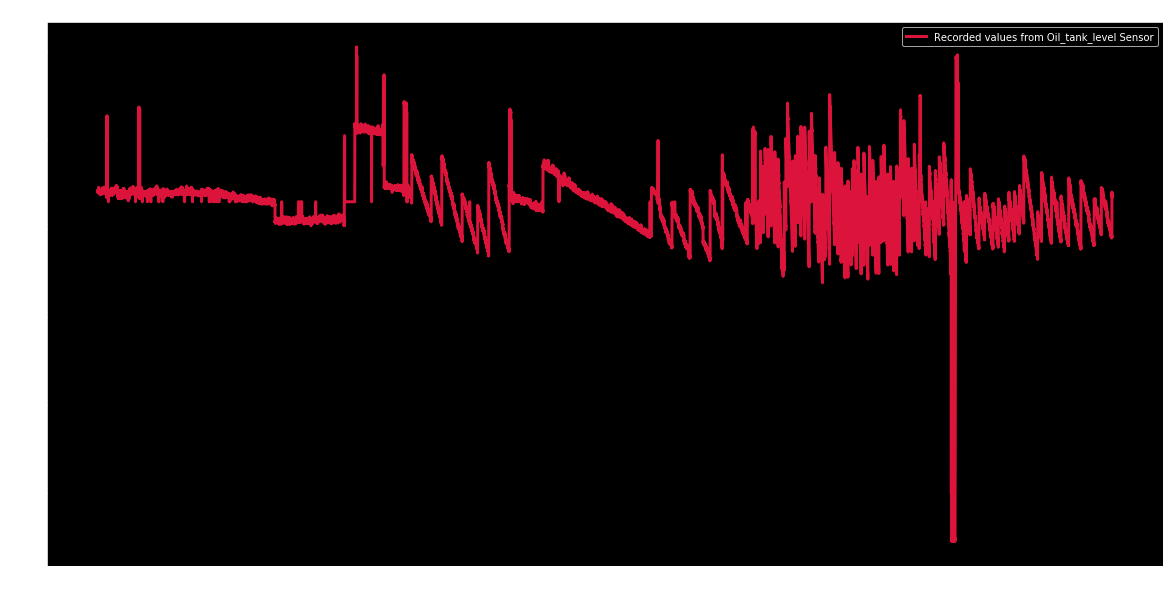

In [7]:
color_list = ('blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 
              'salmon', 'lime', 'aqua', 'indigo', 'crimson')
column_list = list(data.columns)[1:]
count = 0
for a in column_list:
    plt.figure(figsize=(20, 10))
    plt.plot(data['Time'], data[a], linewidth=3, linestyle="-", color=color_list[count], label=f"Recorded values from {a} Sensor")  
    plt.xlabel(r"Timestamp")
    plt.ylabel(r"Values")
    plt.title(f"Line Plot showing Recorded values from {a} Sensor over 5 years")
    plt.legend(loc="upper right")
    count += 1

## Anomaly Detection Tasks

#### Are you able to spot (visually) any anomalies?
Anomalies or outliers are typically data points in a dataset that have characteristics that are different from the standard patterns of behaviour of other data points in the dataset.

Anomalies are typically grouped into three types:
1. Point anomalies (data points that have extremely high or low values from the other data points)
2. Conditional anomalies (data points that differ from other data points of the same context such as an anomaly in particular seasonal patterns of data)
3. Collective anomalies (a collection of data points that differ significantly from the entire dataset)

From the line plots for the sensor recordings shown above, it is very easy to visually spot `point anomalies` because of their extreme values that are different from the rest of the dataset.

However, it is a lot more difficult and near impossible to visually spot other anomalies/outliers that are conditional and/or collective due to their contextual and domain-specific natures.

Use of standard data science and statistics methods are very handy, however, in revealing if anomalies that are conditional and/or collective exist in this dataset.

#### Could there be threshold values that are being violated (above or below control limits?) for 'normal' operation? 
From the sensor plots above, there are clearly lots of threshold values that are being violated (above or below control limits) during 'normal' operations. Examples are listed below:
1. Within 2017, the Oil tank level sensor recorded a value of less than zero which does not make sense when assessing this practically.
2. Also within 2017, the Fuel pressure sensor recorded a negative pressure which is clearly not reasonable judging from the values of the rest of the dataset
3. A negative reading was observed from the outlet average temperature sensor
4. Worst of all is a -2000 reading observed from the Discharge average temperature sensor which is even less than absolute zero temperature.

Clearly these amongst others are snippets of data that show that threshold values are being violated during 'normal' operations.


#### How to set thresholds to detect any of these anomalies.
To set thresholds to detect particularly point anomalies, two statistical methods come to mind:
1. Using the Standard deviation method (this method applies if the dataset is assumed to show a normal distribution)
2. Using the Interquartile range method (this method applies if the dataset does not show a normal or a Gaussian distribution)

With the Standard deviation method, the dataset is typically first standardized to a z-score with a variance of 1 and a mean of 0. After this done, outliers are defined as any points that are 3 standard deviations away from the mean on both sides.

With the Interquartile range method, the interquartile range defines data within the 50th percentile which is assumed to constitute the body of the data. Any data point below a factor *k* of the 25th percentile or above *k* of the 75th percentile are defined as outliers. *k* is normally assumed to be `1.5`. A value of `3` and above is used to filter out outliers that at the extreme ranges.

Beside the statistical methods discussed above, to generally detect point, contextual and collective anomalies, machine-learning models from the sklearn toolkit provide robust methods to reasonably set thresholds detect the anomalies. 

Also, a blend of using the Facebook Prophet toolkit and the fastai module provide a similarly comprehensive framework for detecting point, contextual and collective anomalies


#### (Optional): Can you try applying any of the skelarn outlier detection techniques? Does that catch the anomalies we say visually



I will be using the Isolation Forest algorithm which is one of the sklearn's outlier detection techniques to show visually the inherent anomalies in the data.

In [8]:
data.head()

,Time,Rotor_shaft_speed,Unit_Speed_RPM,Lower_shaft_speed,Line_Speed_RPM,Pressure_diff1,Pressure_diff2,Pressure_diff3,Pressure_loss,Inlet_Avg_Temp,Discharge_Avg_Temp,Discharge_Pressure,Outlet_Avg_Temp,Fuel_pressure,Lubricant_Temp,Oil_tank_level
0,2013-01-30 00:00:00,99.9686,5098.3989,101.1093,4721.8066,77.7725,76.7162,76.3368,167.0344,22.3443,329.2889,8.8556,492.9221,19.8115,54.6645,68.6119
1,2013-01-30 01:00:00,99.9924,5099.6123,101.5489,4742.3330,78.2751,76.8406,77.2332,167.0796,22.1642,329.4370,8.8732,494.6340,19.7604,54.6888,68.3893
2,2013-01-30 02:00:00,99.9839,5099.1792,101.5569,4742.7080,76.9854,76.0533,75.9253,167.3895,22.1140,328.9085,8.8686,493.6359,19.7733,54.7309,68.3634
3,2013-01-30 03:00:00,100.0077,5100.3926,102.1171,4768.8687,78.2802,77.3913,77.0074,168.4393,21.4434,328.3918,8.9081,493.5725,19.7667,54.6808,68.2874
4,2013-01-30 04:00:00,99.9924,5099.6123,102.1025,4768.1865,77.3884,76.7575,76.1018,168.6652,21.0625,328.3006,8.9256,494.1184,19.7841,54.5959,68.4671


In [9]:
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)
size = int(len(data) * 0.10)

In [10]:
df = data.iloc[:, 0:3] .copy()
df.head()

,Time,Rotor_shaft_speed,Unit_Speed_RPM
0,2013-01-30 00:00:00,99.9686,5098.3989
1,2013-01-30 01:00:00,99.9924,5099.6123
2,2013-01-30 02:00:00,99.9839,5099.1792
3,2013-01-30 03:00:00,100.0077,5100.3926
4,2013-01-30 04:00:00,99.9924,5099.6123


In [11]:
# Creating mini-dataframes for each of the 15 sensor parameters
# Also, creating training and test dataframes for each of the 15 sensor parameters

for x in range(1,16):
    globals()['df_%s' %x] = data.iloc[:,0:x+1].copy()
    if x > 0:
        globals()['df_%s' %x].drop(globals()['df_%s' %x].iloc[:,1:-1] , axis = 1, inplace = True) # to create variables like (df_1, df_2, etc)
    globals()['df_%s_train' %x] = globals()['df_%s' %x][:size].copy() # to create variables like (df_1_train, df_2_train, etc)
    globals()['df_%s_test' %x] = globals()['df_%s' %x][size:].copy() # to create variables like (df_1_test, df_2_test, etc)
    
df_5_test.head()

,Time,Pressure_diff1
4400,2013-08-01 09:00:00,83.3240
4401,2013-08-01 10:00:00,83.0560
4402,2013-08-01 11:00:00,84.9164
4403,2013-08-01 12:00:00,84.0943
4404,2013-08-01 13:00:00,83.6586


In [12]:
# Here I am creating a loop to train all 15 sensor parameters using sklearn's Isolation Forest algorithm

for x in range(1,16):
    # the following code will create variables like (if_model_1, if_model_2) with generic Isolation Forest parameters, assuming
    # the stated contamination amount
    globals()['if_model_%s' %x] = IsolationForest(max_samples=1000, contamination = 0.03)
    # the following code will fit the created Isolation Forest models to the associated training datasets
    globals()['if_model_%s' %x].fit(globals()['df_%s_train' %x].drop('Time', axis = 1))

In [13]:
# Here I will proceed with using the created model to perform predictions for expected values in the training and test datasets
# for the 15 sensor parameters

for x in range(1,16):
    globals()['y_pred_train_%s' %x] = globals()['if_model_%s' %x].predict(globals()['df_%s_train' %x].drop('Time', axis = 1))
    globals()['y_pred_test_%s' %x] = globals()['if_model_%s' %x].predict(globals()['df_%s_test' %x].drop('Time', axis = 1))


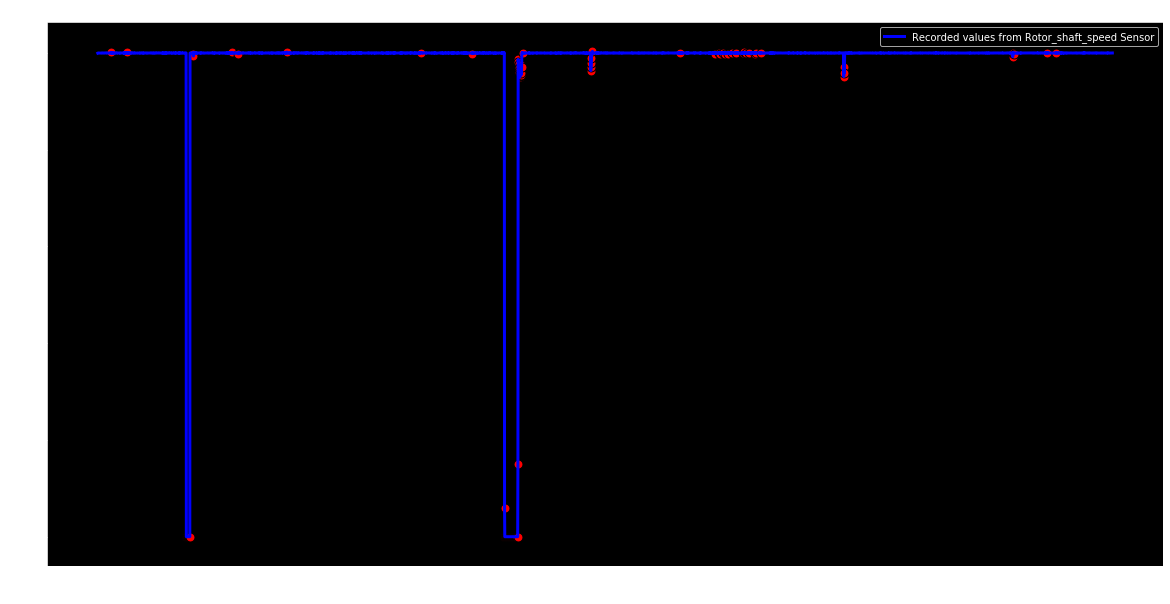

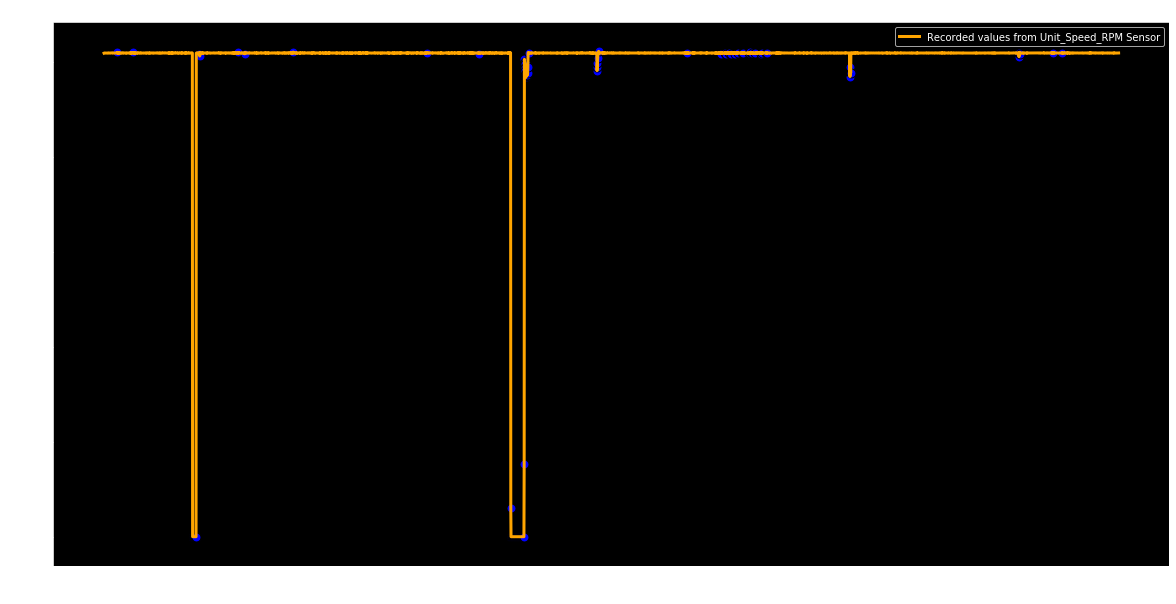

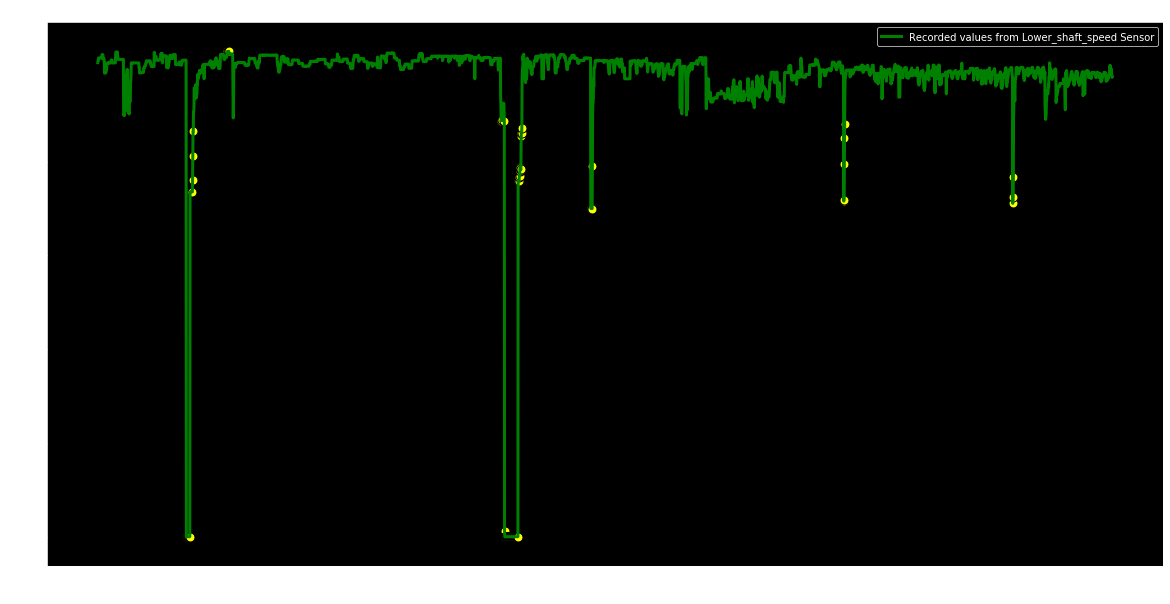

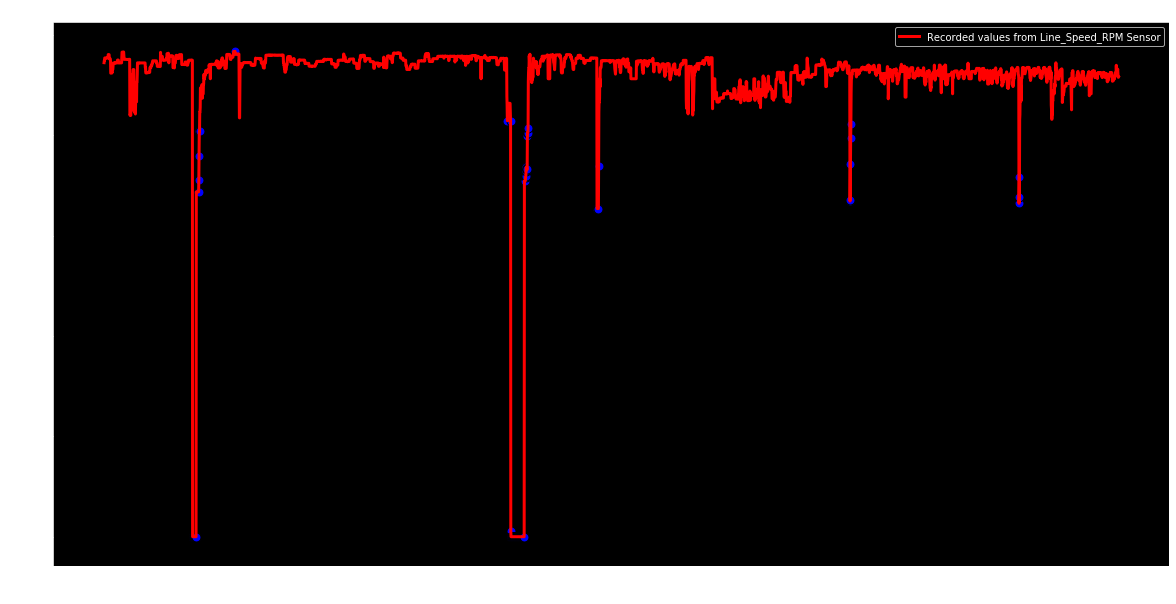

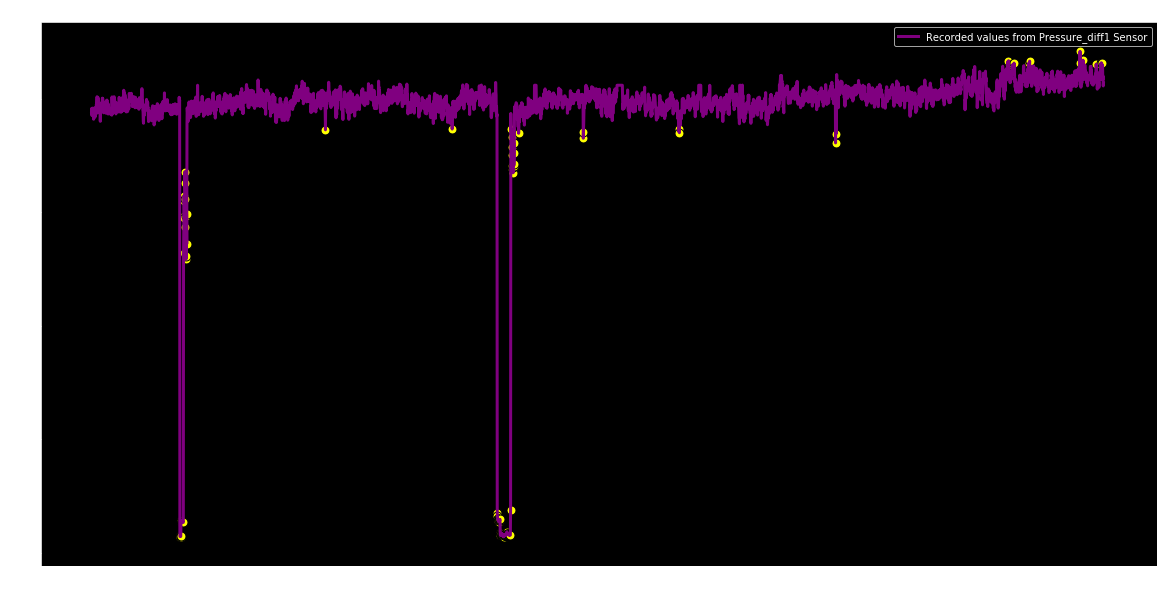

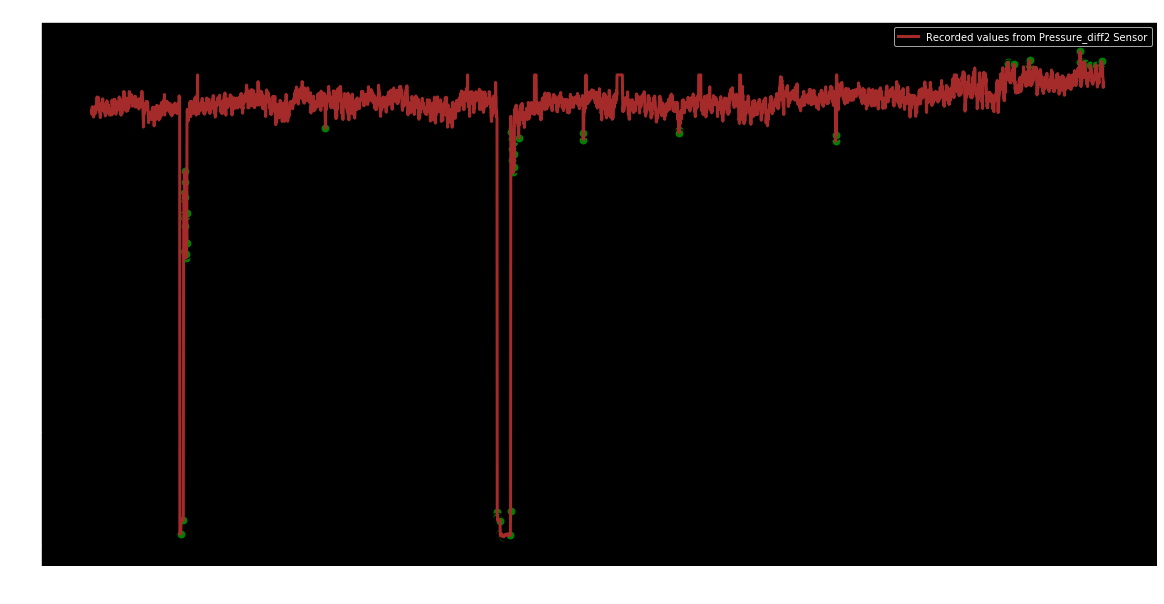

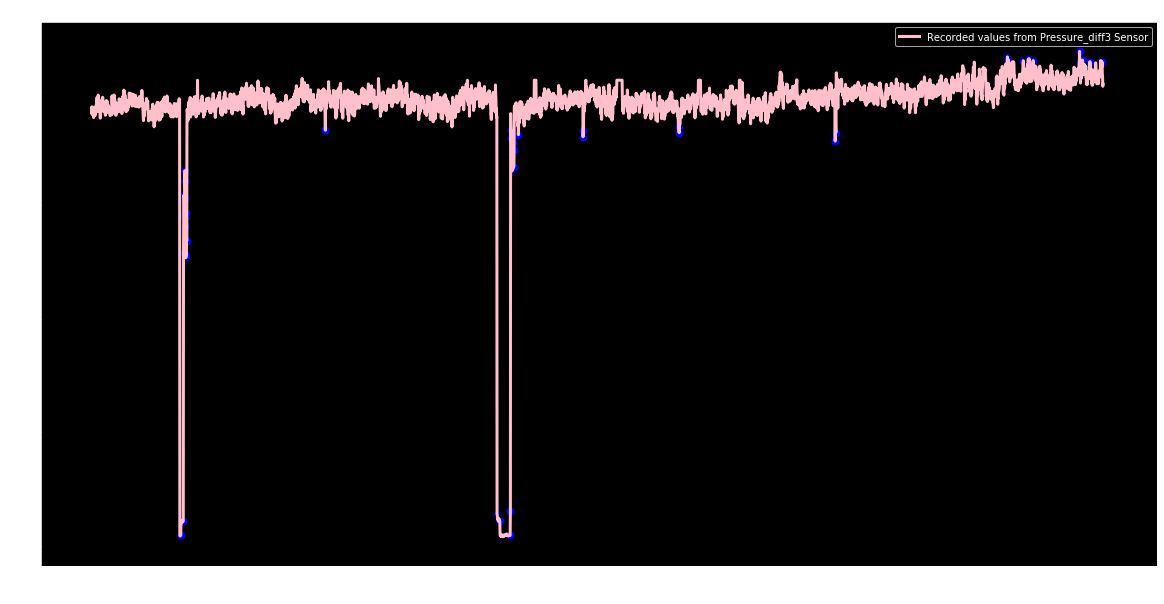

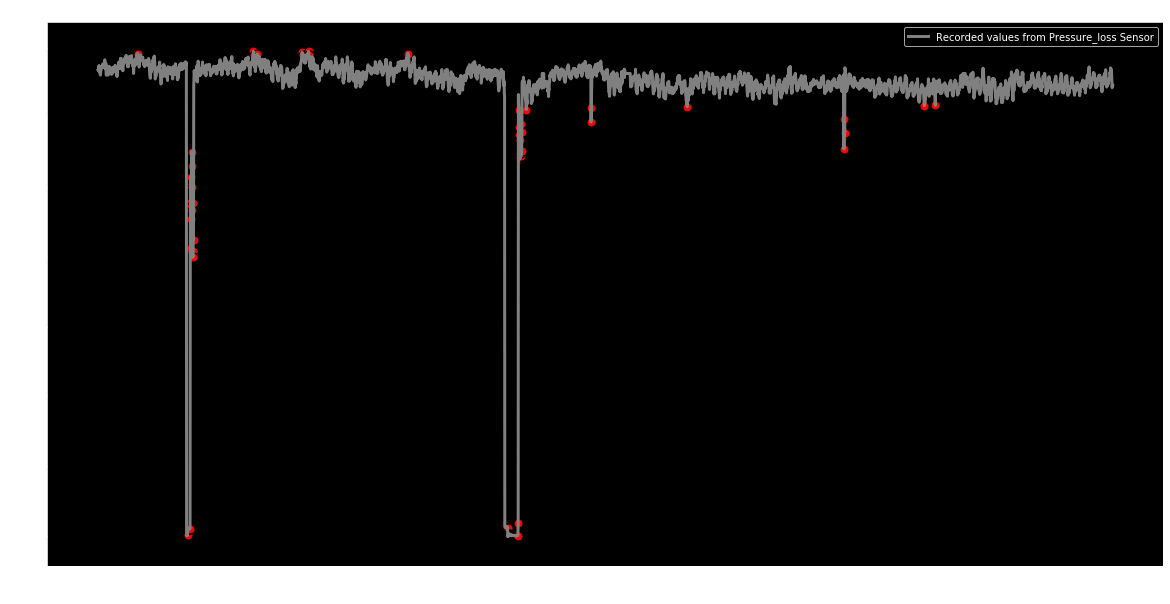

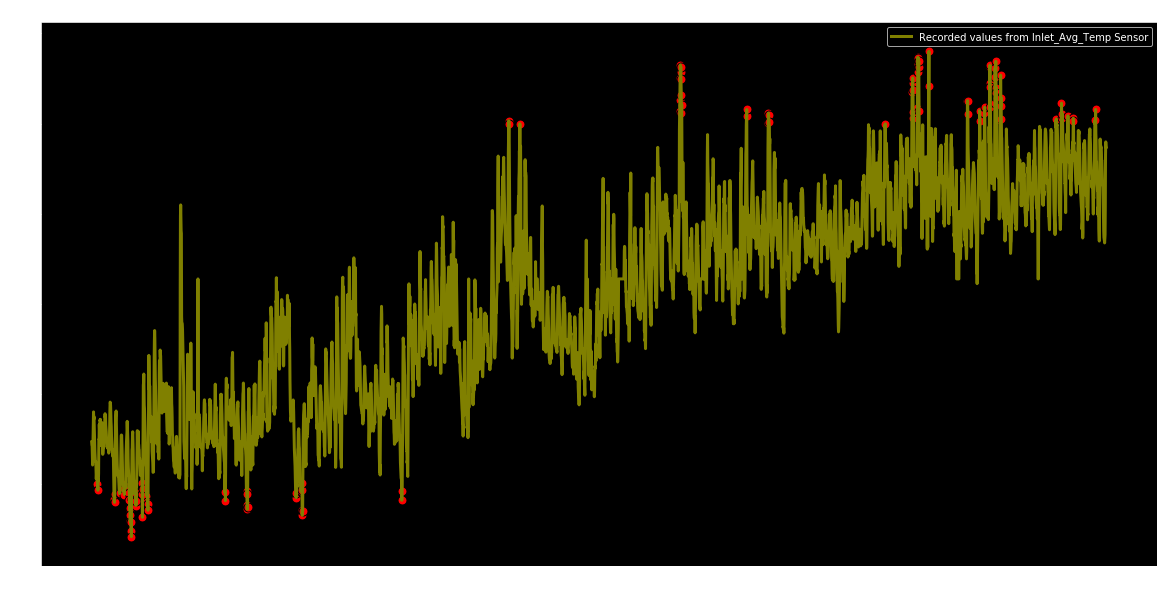

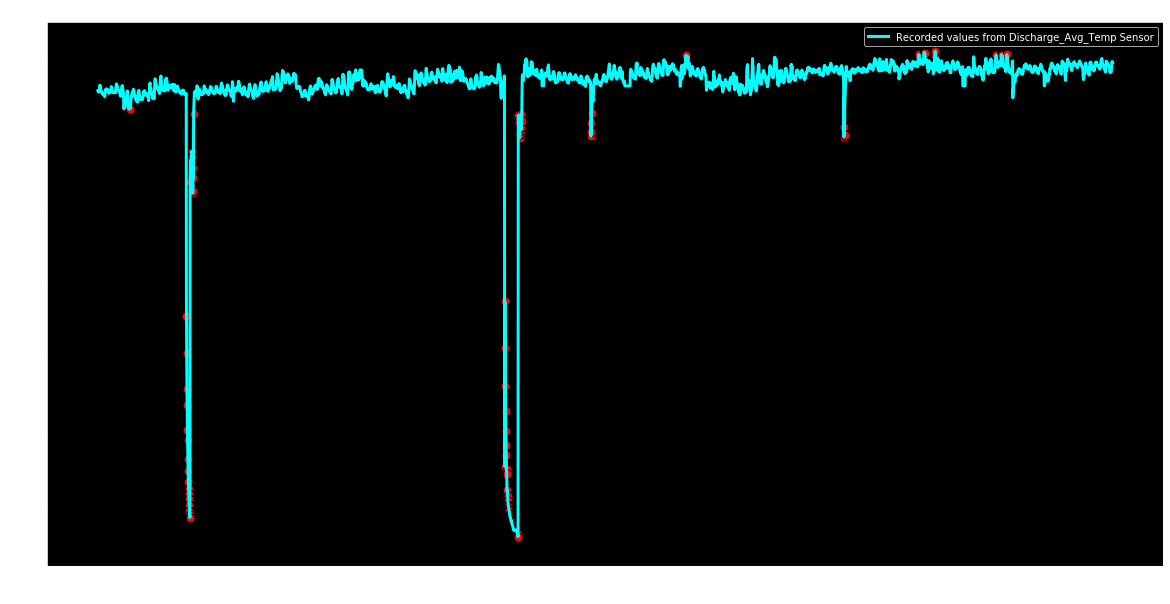

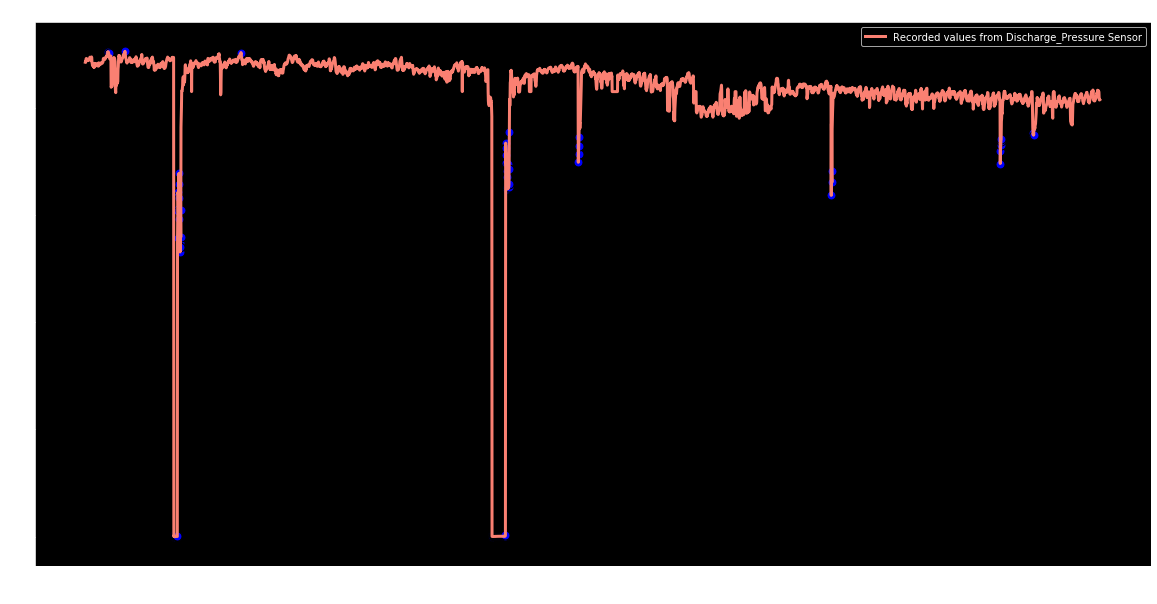

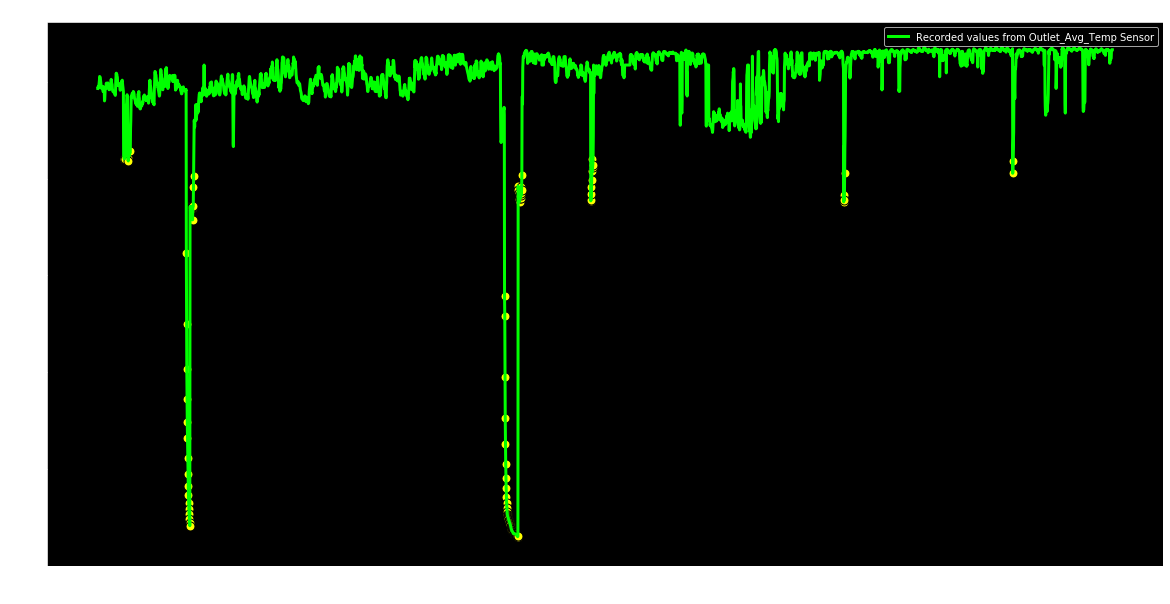

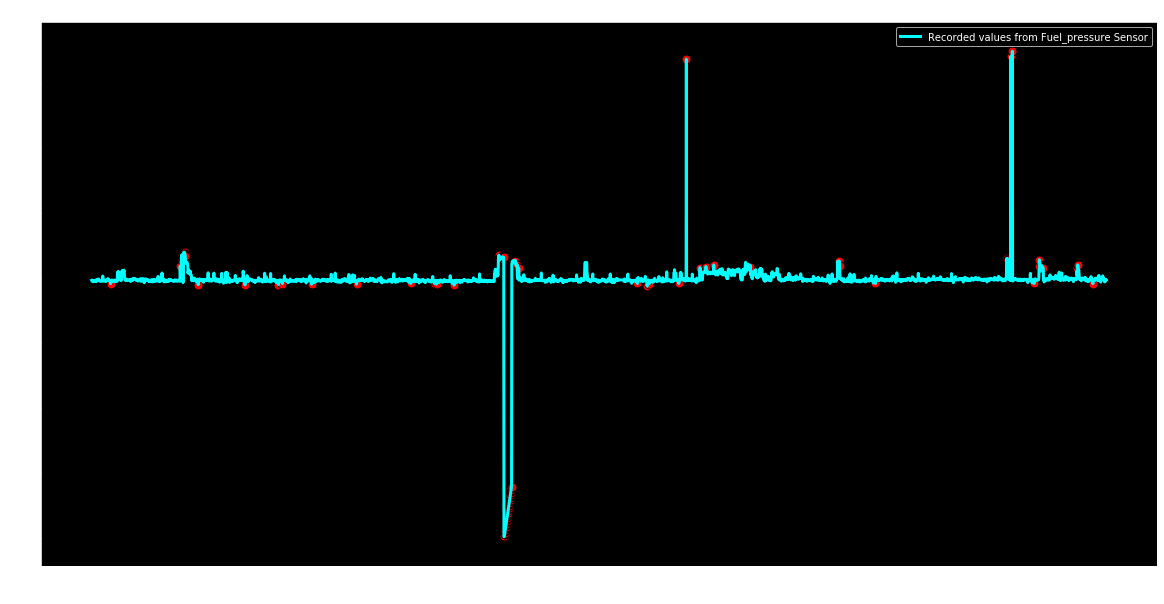

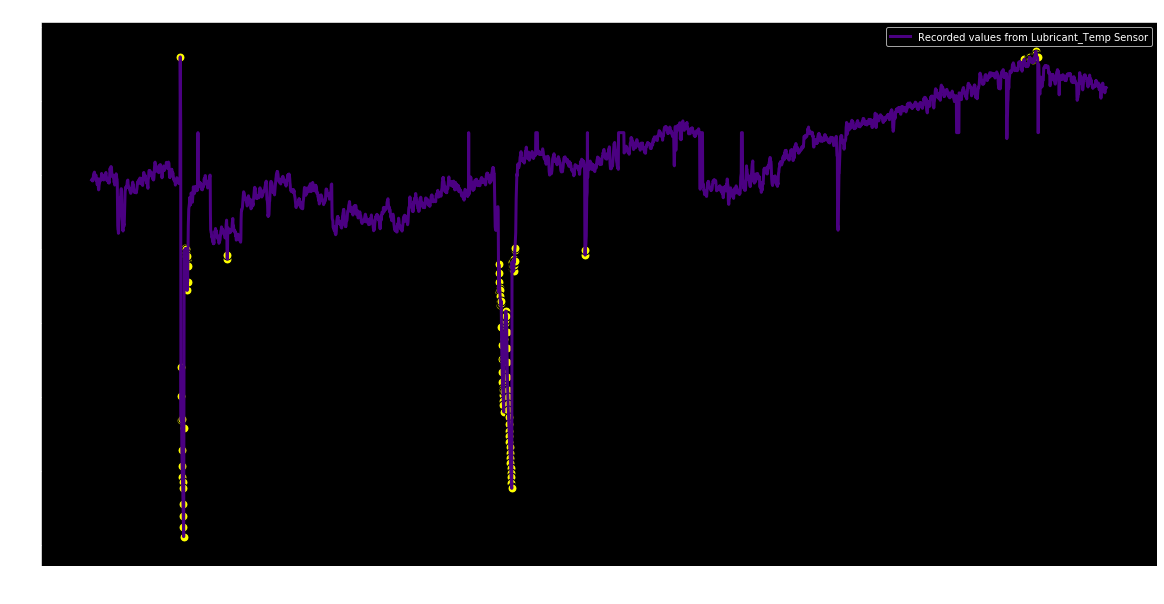

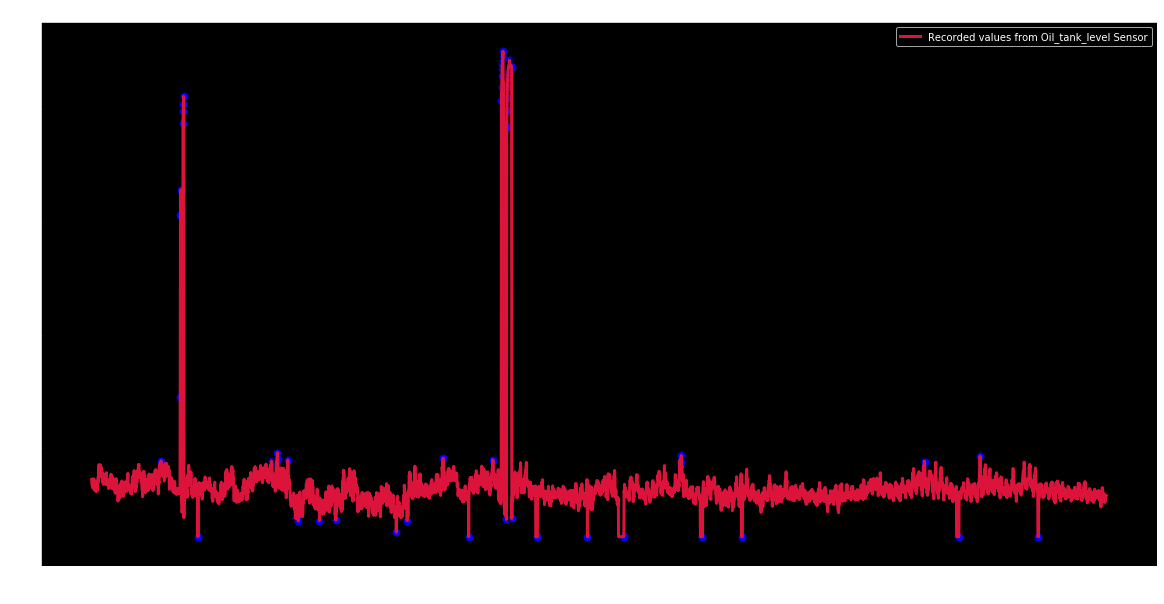

In [14]:
color_list2 = ('red', 'blue', 'yellow', 'blue', 'yellow', 'green', 'blue', 'red', 'red', 'red', 
              'blue', 'yellow', 'red', 'yellow', 'blue')

for x in range(1,16):
    plt.figure(figsize=(20, 10))
    globals()['df_%s_train' %x] = globals()['df_%s_train' %x].assign(y = globals()['y_pred_train_%s' %x])
    plt.plot(globals()['df_%s_train' %x]['Time'], globals()['df_%s_train' %x][column_list[x-1]], linewidth=3, 
             linestyle="-",color=color_list[x-1], label=f"Recorded values from {column_list[x-1]} Sensor")
    plt.scatter(globals()['df_%s_train' %x]['Time'][globals()['df_%s_train' %x].y == -1],
                globals()['df_%s_train' %x][column_list[x-1]][globals()['df_%s_train' %x].y == -1], c=color_list2[x-1], s=20*4, 
                edgecolor='k')
    plt.xlabel(r"Timestamp")
    plt.ylabel(r"Values")
    plt.title(f"Line Plot showing Recorded values (training data) from {column_list[x-1]} Sensor overlaid with the detected anomalies")
    plt.legend(loc="best")
    plt.show()

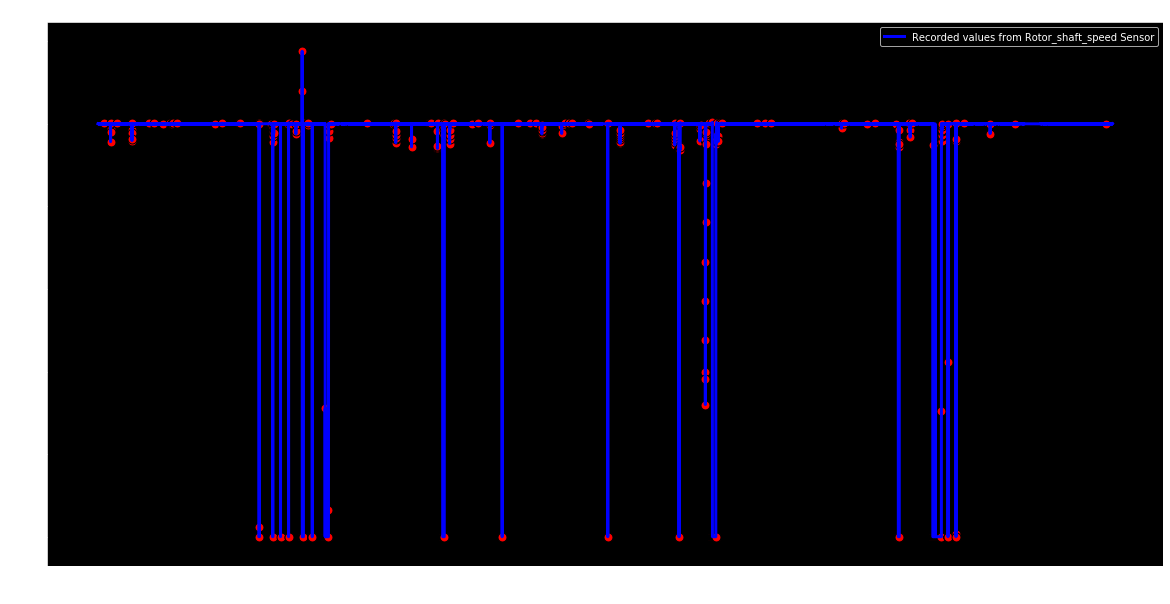

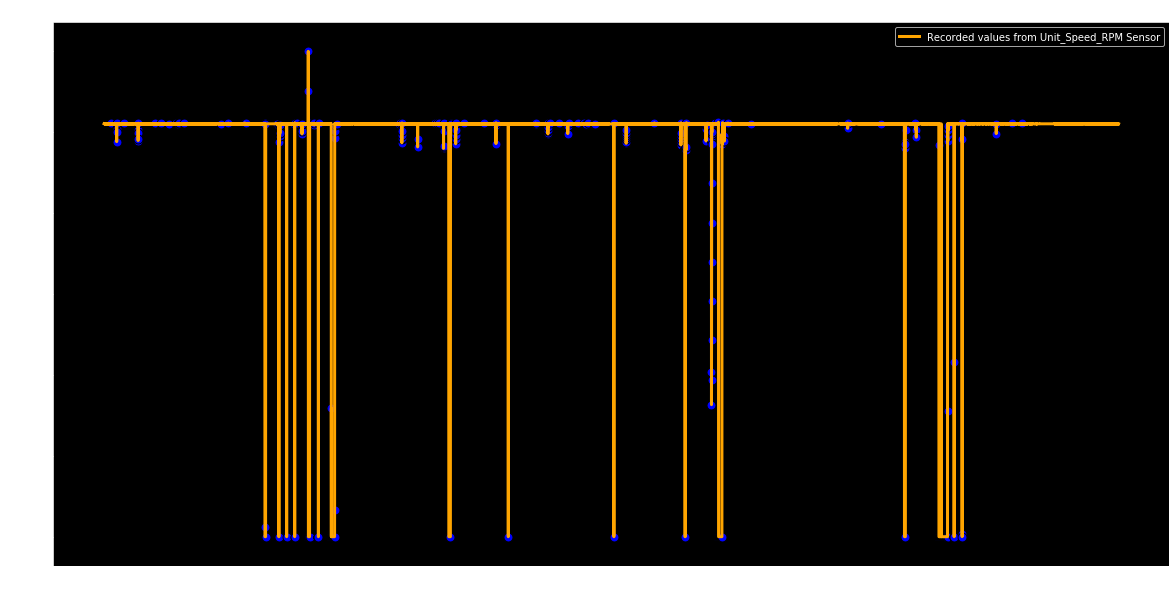

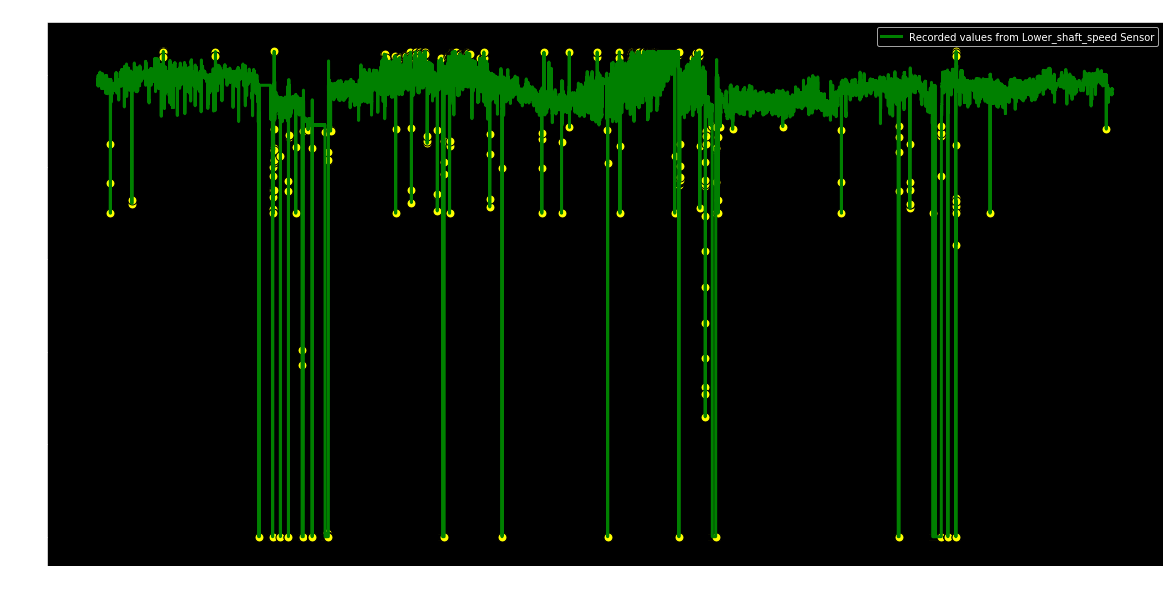

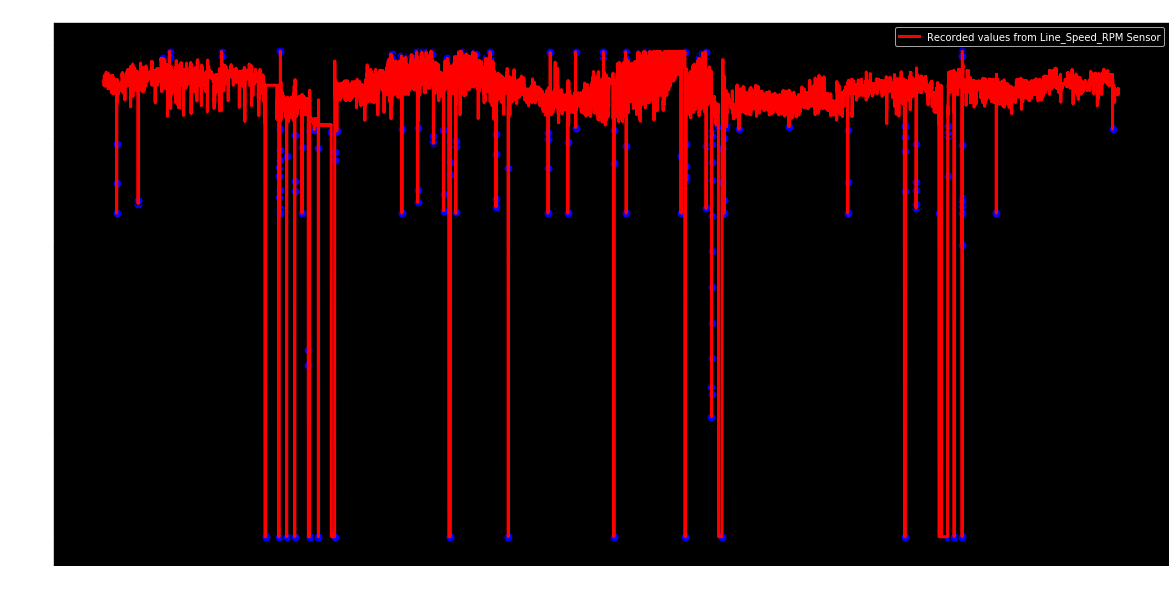

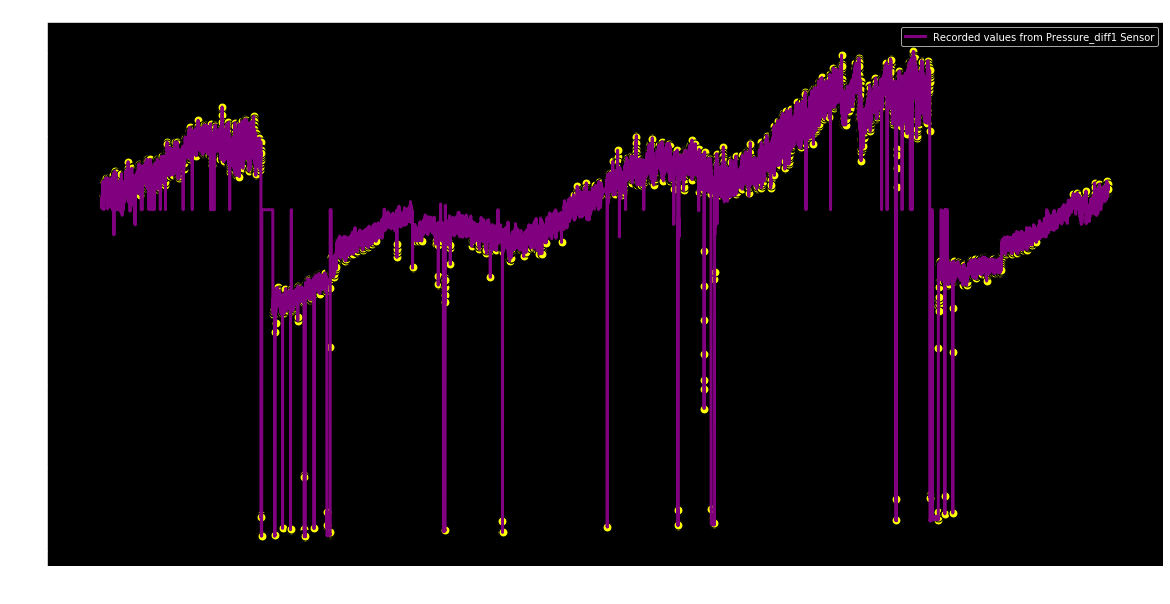

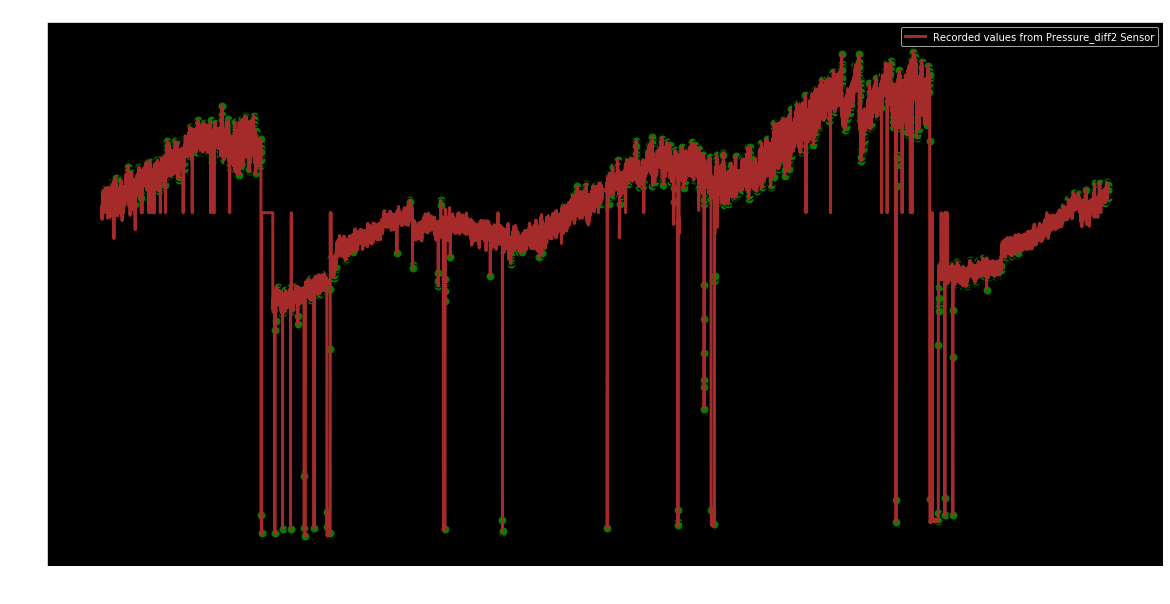

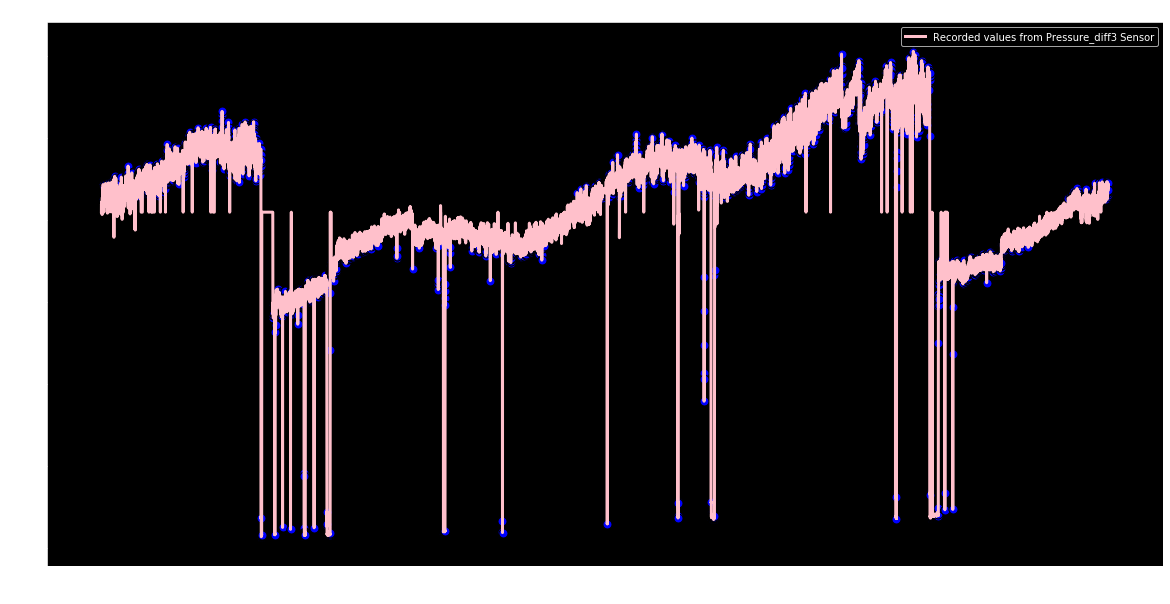

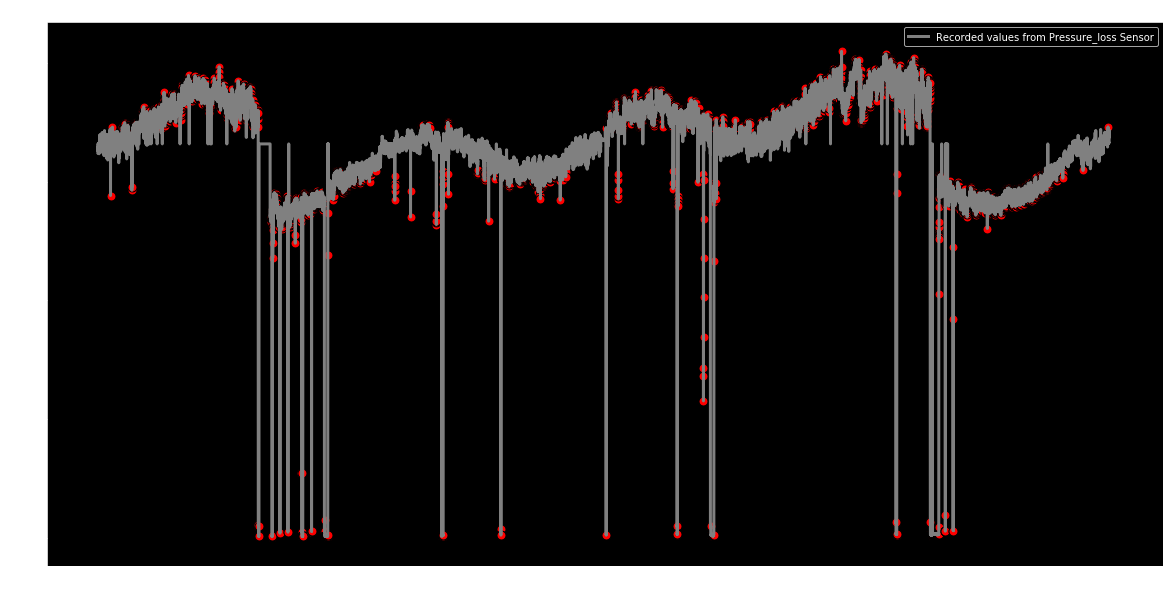

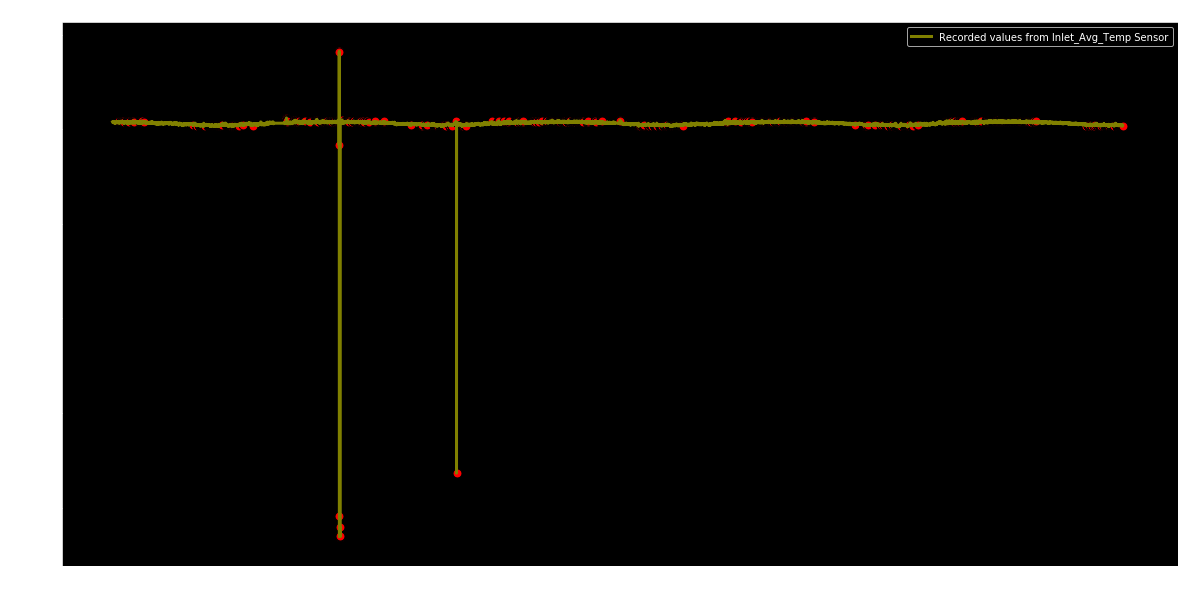

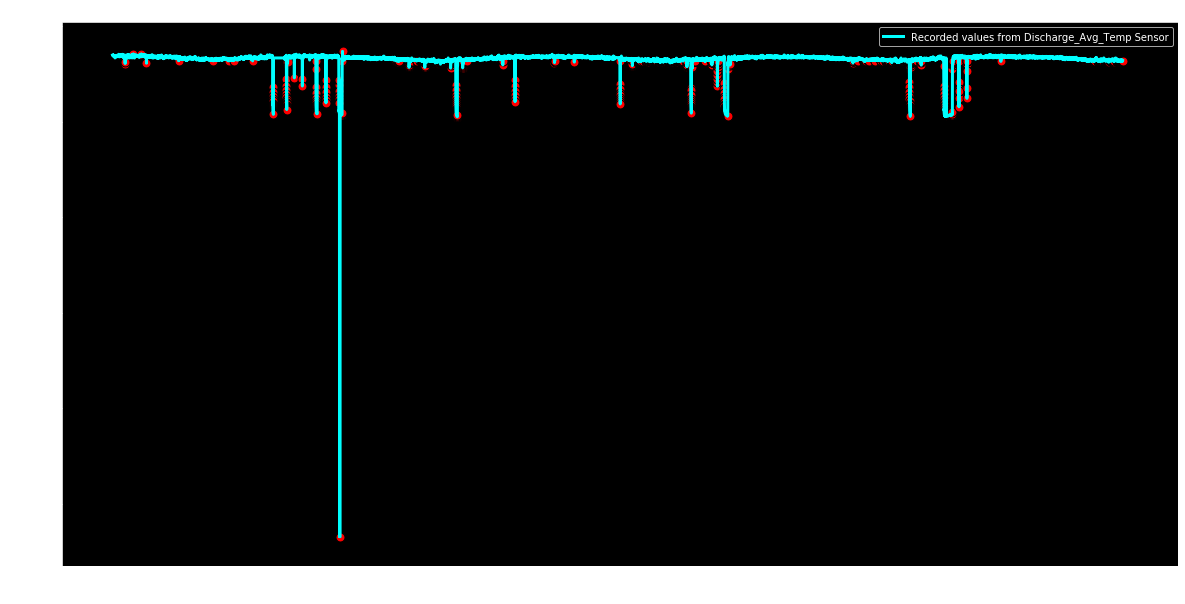

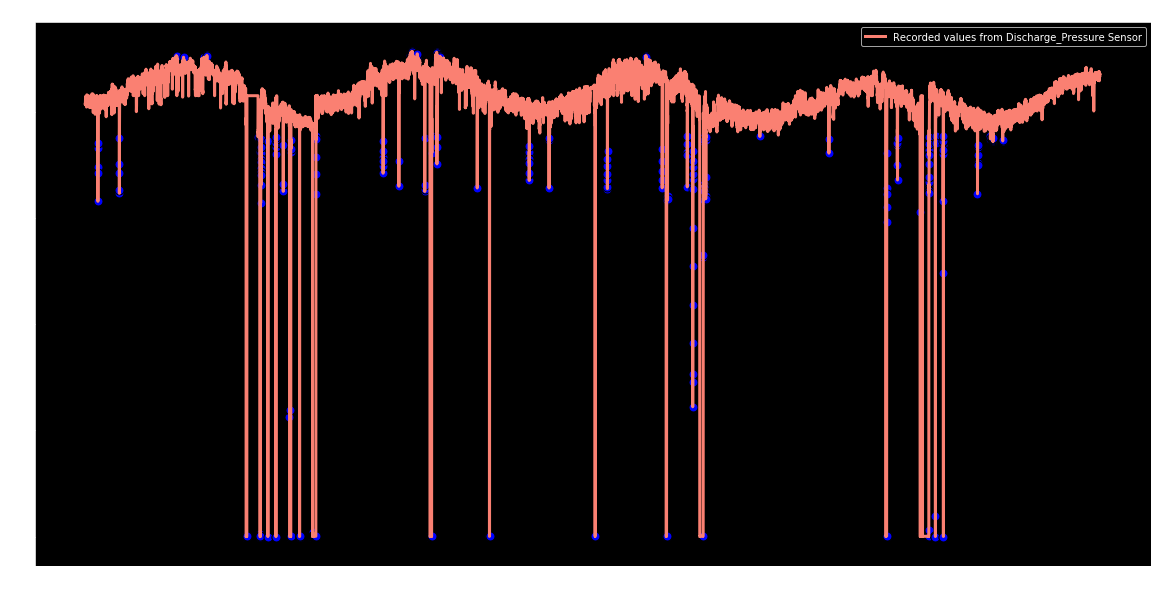

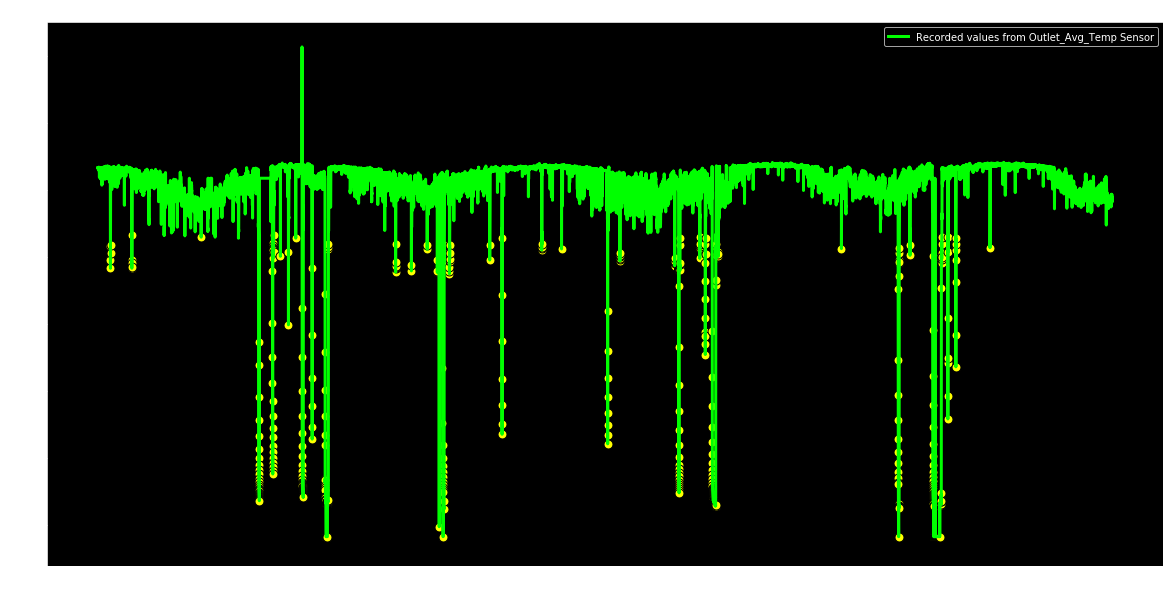

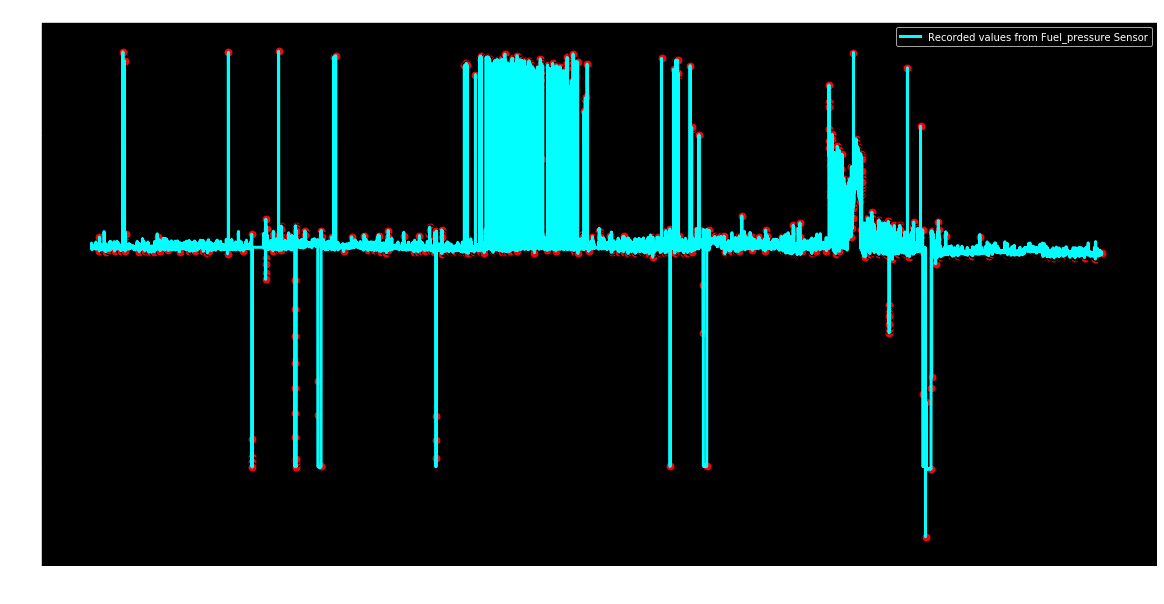

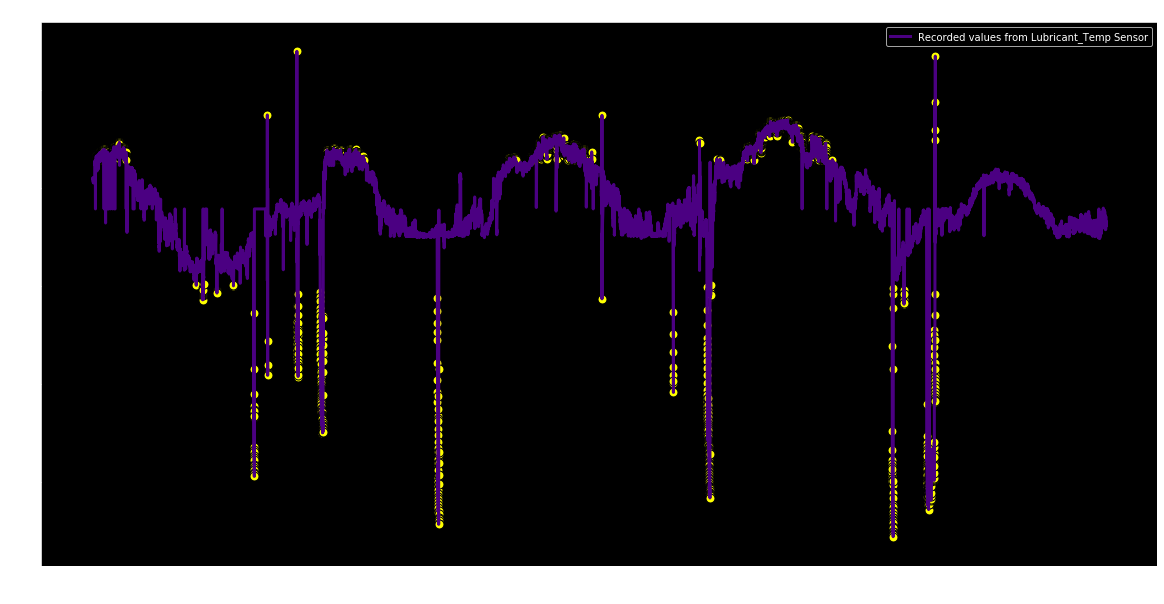

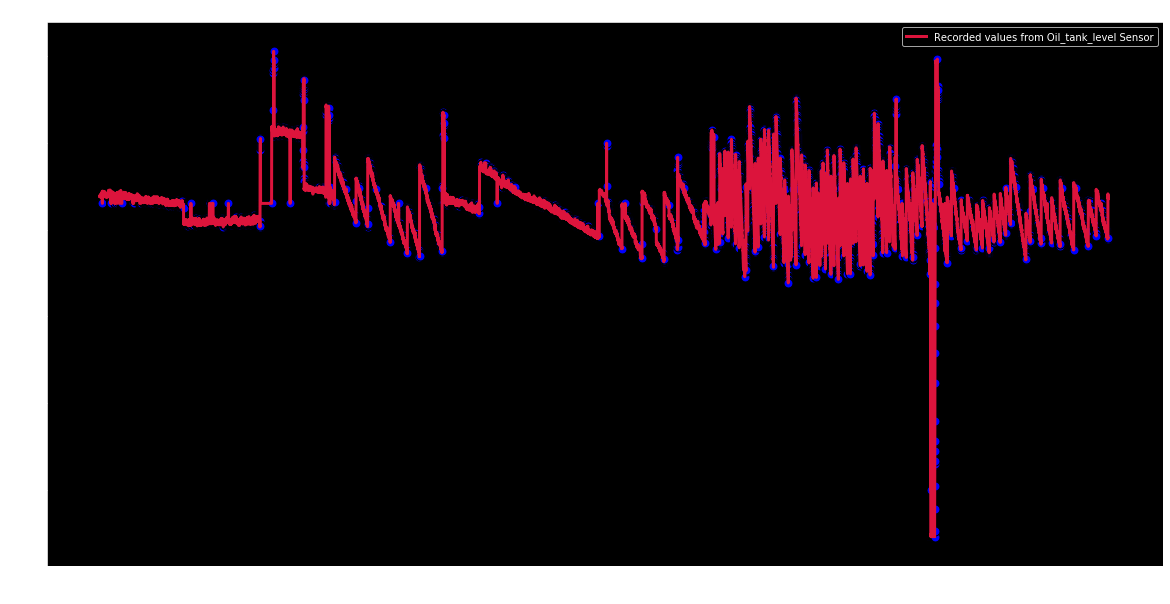

In [15]:
for x in range(1,16):
    plt.figure(figsize=(20, 10))
    globals()['df_%s_test' %x] = globals()['df_%s_test' %x].assign(y = globals()['y_pred_test_%s' %x])
    plt.plot(globals()['df_%s_test' %x]['Time'], globals()['df_%s_test' %x][column_list[x-1]], linewidth=3, 
             linestyle="-",color=color_list[x-1], label=f"Recorded values from {column_list[x-1]} Sensor")
    plt.scatter(globals()['df_%s_test' %x]['Time'][globals()['df_%s_test' %x].y == -1],
                globals()['df_%s_test' %x][column_list[x-1]][globals()['df_%s_test' %x].y == -1], c=color_list2[x-1], s=20*4, 
                edgecolor='k')
    plt.xlabel(r"Timestamp")
    plt.ylabel(r"Values")
    plt.title(f"Line Plot showing Recorded values (test data) from {column_list[x-1]} Sensor overlaid with the detected anomalies")
    plt.legend(loc="best")
    plt.show()

From the graphs shown above, we can apply sklearn's Isolation Forest algorithm to easily see a number of the anomalies.

### Focus on Fuel Pressure, Lubricant Temperature and Tank Level?
### What metrics could we apply to these?

The parameters to focus on corresponds to the following dataframes:
df_13, df_14, df_15 = Fuel_pressure, Lubricant_Temp, Oil_tank_level

We could use the metric of `deviation from the mean` and then set a threshold. Anything above the maximum threshold is flagged and anything below the minimum threshold is also flagged.


# Conclusions and Recommendations

### Insights: Can we conclude that there are any alarms or anomalies in the data that we are examining?

From the results of the codes shown above in graphs, it is reasonable to conclude that are indeed alarms or anomalies in the examined data, even after filling the null values with the median of the corresponding data columns.

### If you compute the rolling mean (moving averages) for these values and overlay them with the data, can you detect any anomalies?

In [16]:
for x in range(13,16):
    globals()['df_%s' %x]['Rolling_mean_3'] = globals()['df_%s' %x].iloc[:,1].rolling(3).mean()
    globals()['df_%s' %x]['Rolling_mean_3'].fillna(method='backfill', inplace=True)
    globals()['df_%s' %x]['Rolling_mean_8'] = globals()['df_%s' %x].iloc[:,1].rolling(8).mean()
    globals()['df_%s' %x]['Rolling_mean_8'].fillna(method='backfill', inplace=True)
    globals()['df_%s' %x]['Rolling_mean_24'] = globals()['df_%s' %x].iloc[:,1].rolling(24).mean()
    globals()['df_%s' %x]['Rolling_mean_24'].fillna(method='backfill', inplace=True)
    globals()['df_%s' %x]['Low_threshold'] = globals()['df_%s' %x].iloc[:,1].mean() - (2 * globals()['df_%s' %x].iloc[:,1].std())
    globals()['df_%s' %x]['High_threshold'] = globals()['df_%s' %x].iloc[:,1].mean() + (2 * globals()['df_%s' %x].iloc[:,1].std())
    globals()['df_%s' %x]['Low_max_threshold'] = globals()['df_%s' %x].iloc[:,1].mean() - (3 * globals()['df_%s' %x].iloc[:,1].std())
    globals()['df_%s' %x]['High_max_threshold'] = globals()['df_%s' %x].iloc[:,1].mean() + (3 * globals()['df_%s' %x].iloc[:,1].std())

df_15.head()

,Time,Oil_tank_level,Rolling_mean_3,Rolling_mean_8,Rolling_mean_24,Low_threshold,High_threshold,Low_max_threshold,High_max_threshold
0,2013-01-30 00:00:00,68.6119,68.454867,68.389112,68.378204,49.883818,81.222795,42.049074,89.05754
1,2013-01-30 01:00:00,68.3893,68.454867,68.389112,68.378204,49.883818,81.222795,42.049074,89.05754
2,2013-01-30 02:00:00,68.3634,68.454867,68.389112,68.378204,49.883818,81.222795,42.049074,89.05754
3,2013-01-30 03:00:00,68.2874,68.346700,68.389112,68.378204,49.883818,81.222795,42.049074,89.05754
4,2013-01-30 04:00:00,68.4671,68.372633,68.389112,68.378204,49.883818,81.222795,42.049074,89.05754


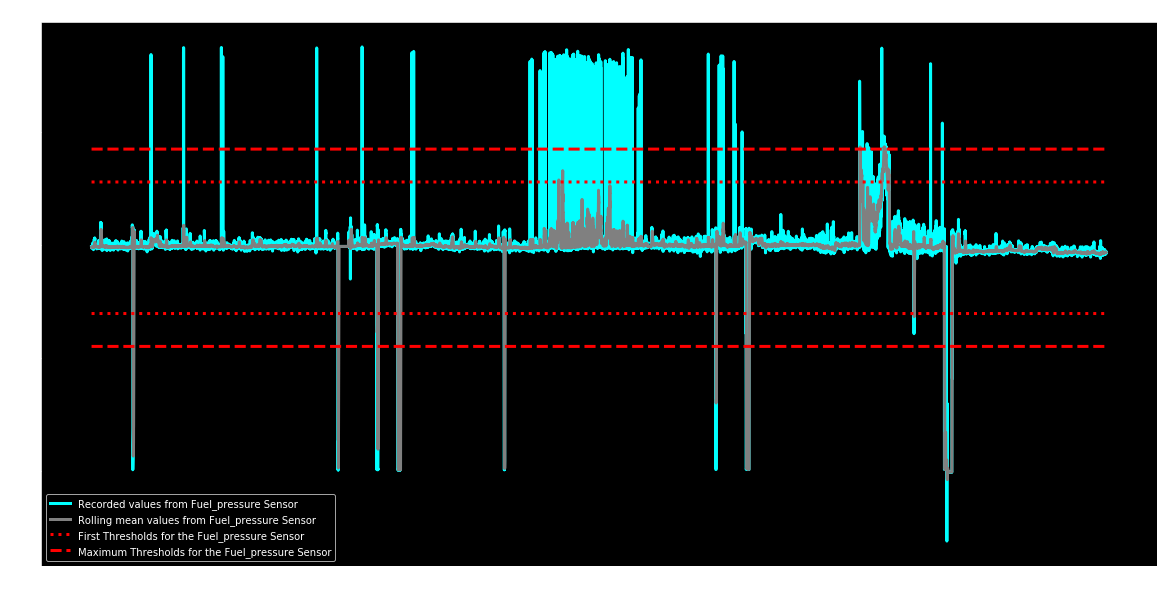

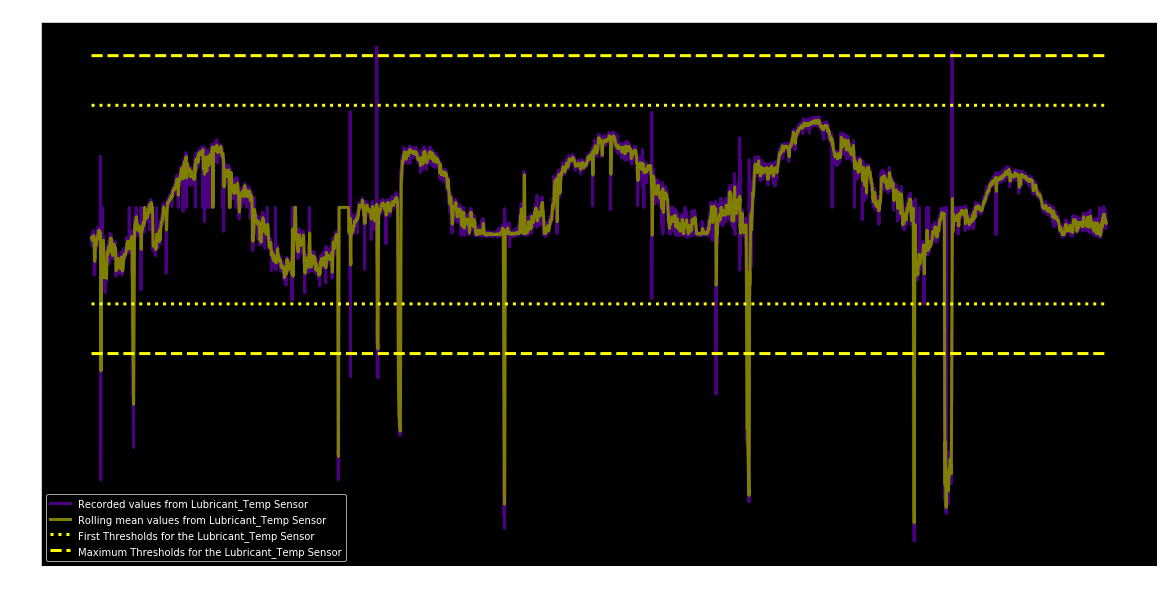

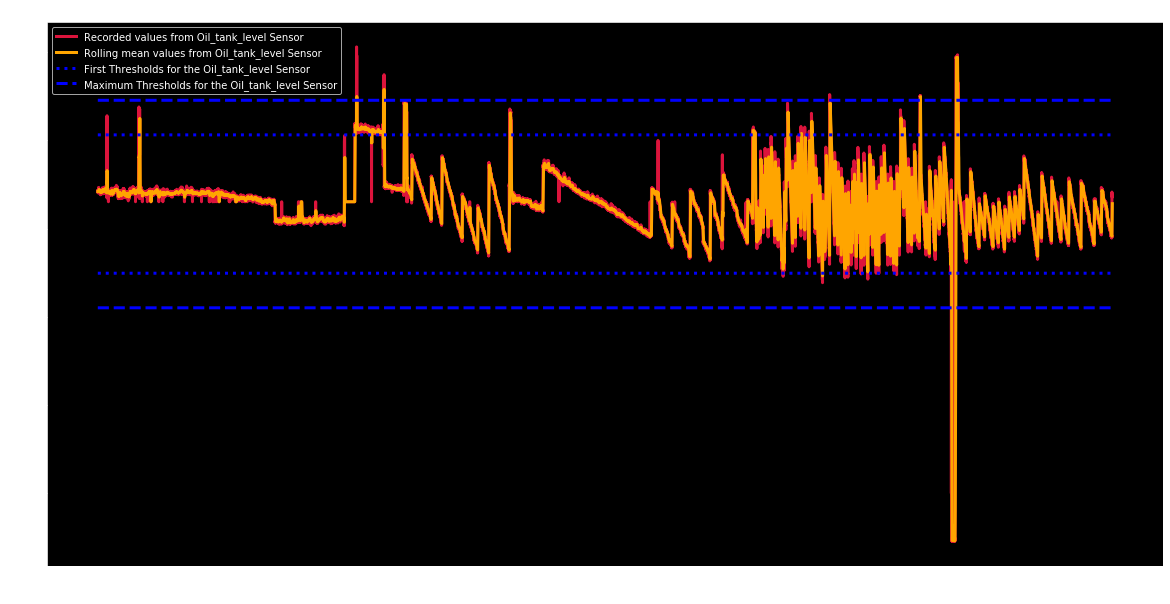

In [17]:
color_list2 = ('red', 'blue', 'yellow', 'blue', 'yellow', 'green', 'blue', 'red', 'red', 'red', 
              'blue', 'yellow', 'red', 'yellow', 'blue')


for x in range(13,16):
    plt.figure(figsize=(20, 10))
    plt.plot(globals()['df_%s' %x]['Time'], globals()['df_%s' %x].iloc[:,1], linewidth=3, 
             linestyle="-",color=color_list[x-1], label=f"Recorded values from {column_list[x-1]} Sensor")
    plt.plot(globals()['df_%s' %x]['Time'], globals()['df_%s' %x].iloc[:,4], linewidth=3, 
             linestyle="-",color=color_list[np.random.randint(x-1)], label=f"Rolling mean values from {column_list[x-1]} Sensor")
    
    plt.plot(globals()['df_%s' %x]['Time'], globals()['df_%s' %x].iloc[:,5], linewidth=3, 
             linestyle="dotted",color=color_list2[x-1], label=f"First Thresholds for the {column_list[x-1]} Sensor")
    
    plt.plot(globals()['df_%s' %x]['Time'], globals()['df_%s' %x].iloc[:,6], linewidth=3, 
             linestyle="dotted",color=color_list2[x-1])
    
    plt.plot(globals()['df_%s' %x]['Time'], globals()['df_%s' %x].iloc[:,7], linewidth=3, 
             linestyle="--",color=color_list2[x-1], label=f"Maximum Thresholds for the {column_list[x-1]} Sensor")
    
    plt.plot(globals()['df_%s' %x]['Time'], globals()['df_%s' %x].iloc[:,8], linewidth=3, 
             linestyle="--",color=color_list2[x-1])
    
    plt.xlabel(r"Timestamp")
    plt.ylabel(r"Values")
    plt.title(f"Line Plot showing Recorded Values from {column_list[x-1]} Sensor overlaid with Rolling Mean Data")
    plt.legend(loc="best")
    plt.show()

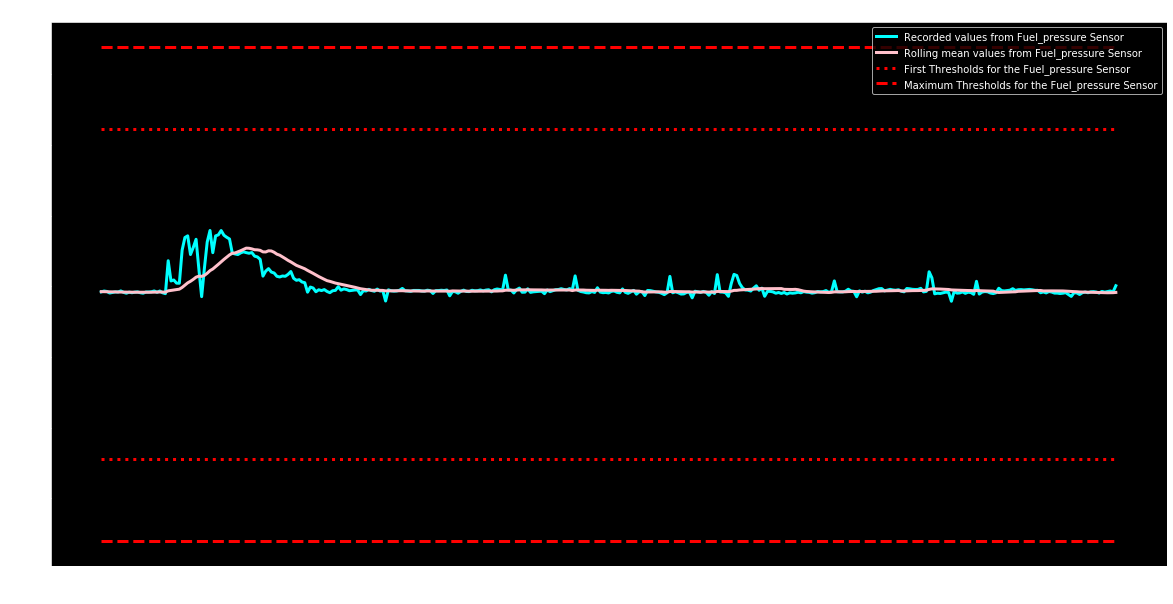

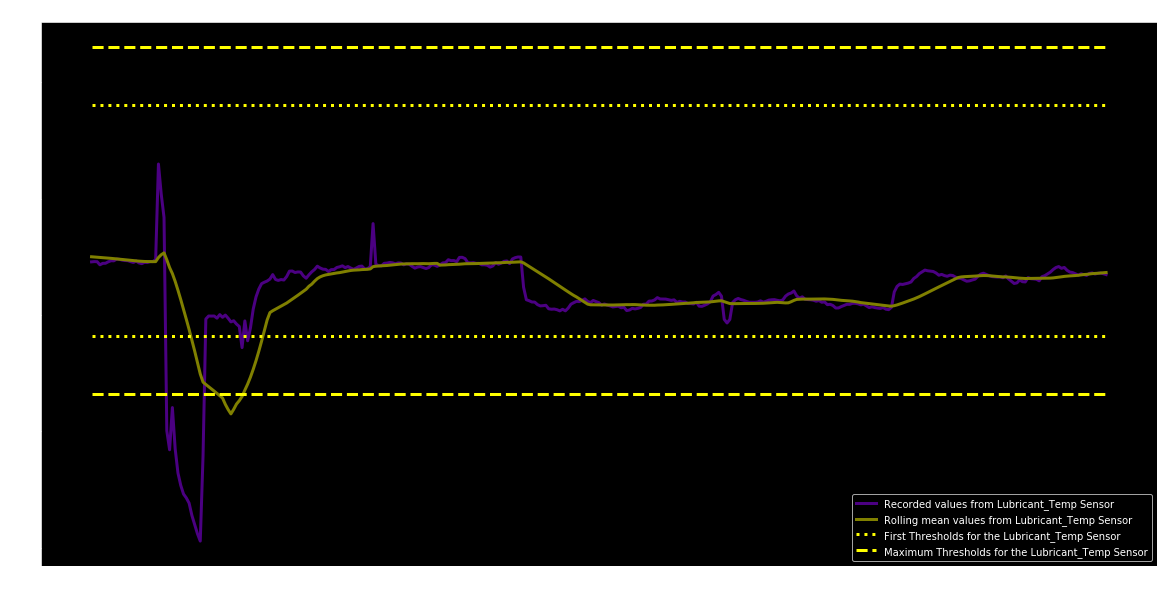

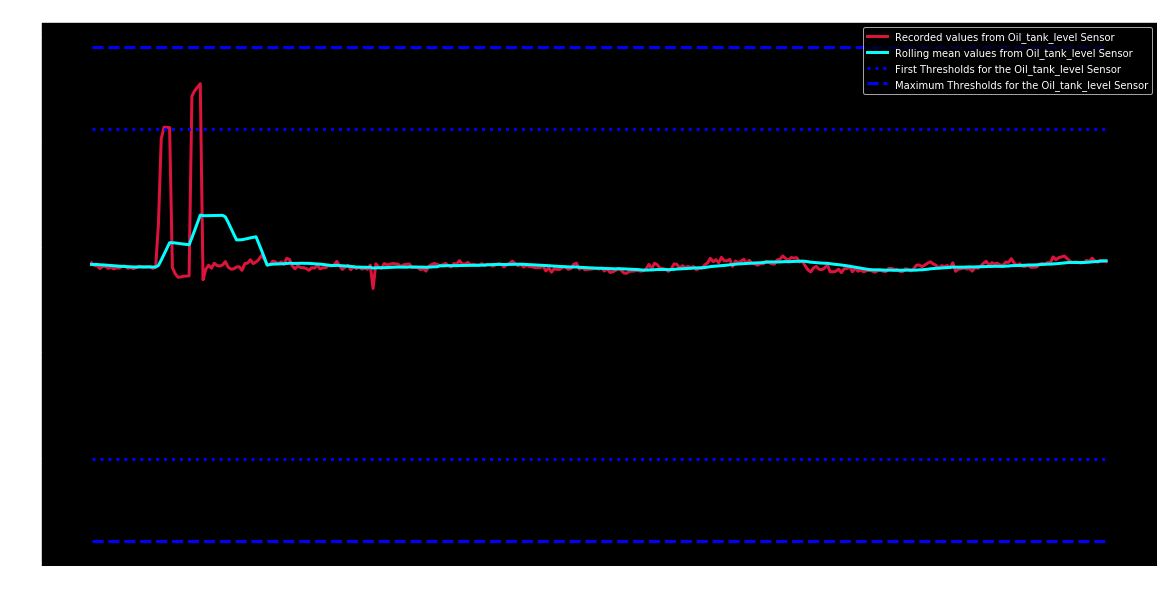

In [18]:
# Here I am putting a window of approximately 1 year to clearly see the relationship between the original dataset
# and the rolling mean computation.

min_view = 360
max_view = 725

for x in range(13,16):
    plt.figure(figsize=(20, 10))
    plt.plot(globals()['df_%s' %x]['Time'][min_view:max_view], globals()['df_%s' %x].iloc[:,1][min_view:max_view], linewidth=3, 
             linestyle="-",color=color_list[x-1], label=f"Recorded values from {column_list[x-1]} Sensor")
    plt.plot(globals()['df_%s' %x]['Time'][min_view:max_view], globals()['df_%s' %x].iloc[:,4][min_view:max_view], linewidth=3, 
             linestyle="-",color=color_list[np.random.randint(x-1, )], label=f"Rolling mean values from {column_list[x-1]} Sensor")
    
    plt.plot(globals()['df_%s' %x]['Time'][min_view:max_view], globals()['df_%s' %x].iloc[:,5][min_view:max_view], linewidth=3, 
             linestyle="dotted",color=color_list2[x-1], label=f"First Thresholds for the {column_list[x-1]} Sensor")
    
    plt.plot(globals()['df_%s' %x]['Time'][min_view:max_view], globals()['df_%s' %x].iloc[:,6][min_view:max_view], linewidth=3, 
             linestyle="dotted",color=color_list2[x-1])
    
    plt.plot(globals()['df_%s' %x]['Time'][min_view:max_view], globals()['df_%s' %x].iloc[:,7][min_view:max_view], linewidth=3, 
             linestyle="--",color=color_list2[x-1], label=f"Maximum Thresholds for the {column_list[x-1]} Sensor")
    
    plt.plot(globals()['df_%s' %x]['Time'][min_view:max_view], globals()['df_%s' %x].iloc[:,8][min_view:max_view], linewidth=3, 
             linestyle="--",color=color_list2[x-1])
    
    plt.xlabel(r"Timestamp")
    plt.ylabel(r"Values")
    plt.title(f"Line Plot showing Expanded View of Recorded Values from {column_list[x-1]} Sensor overlaid with Rolling Mean Data")
    plt.legend(loc="best")
    plt.show()

From the graphs shown above, the rolling mean did not clearly detect which of the data points were anomalies. It only appeared to show the general trend of the data at different points in time.

The use of thresholds, however, helped to show visually when the dataset was beyond normal limits for possible intervention by interested stakeholders.